In [6]:
using ITensors
using PyPlot

# The model
$$H=t\sum_{i,\sigma} c^\dagger_{i,\sigma} c_{i+1,\sigma} +\mathrm{h.c.}+U\sum_i n_{i,\uparrow}n_{i,\downarrow}$$

In [11]:
function Hubbard_Hamiltonian(sites,U)
    """
    t = 1
    """
    L = length(sites)
    ampo = OpSum()

    for i = 1:L-1
        ampo += -1, "Cdagup",i,"Cup",i+1
        ampo += -1, "Cdagup",i+1,"Cup",i
        ampo += -1, "Cdagdn",i,"Cdn",i+1
        ampo += -1, "Cdagdn",i+1,"Cdn",i
    end
    for i = 1:L
        ampo += U, "Nup", i, "Ndn", i
    end
    return MPO(ampo,sites)
end

function InitialState(L::Int64, Ne::Int64, M::Int64)
    @assert M <= Ne "magnetization has to be smaller than number of electrons"
    @assert iseven(M)*iseven(Ne) || isodd(M)*isodd(Ne) "magnetization and Ne parity has to be opposite"
    println("filling factor is "*string(Ne/2/L))

    Nup = div(Ne + M,2)
    Ndn = div(Ne - M,2)
    
    state0 = []

    if Nup >= Ndn
        for i = 1:L
            if i <= Ndn
                append!(state0,["UpDn"])
            elseif i <= Nup
                append!(state0,["Up"])
            else
                append!(state0,["Emp"])
            end
        end
    else
        for i = 1:L
            if i <= Nup
                append!(state0,["UpDn"])
            elseif i <= Ndn
                append!(state0,["Dn"])
            else
                append!(state0,["Emp"])
            end
        end
    end
    return state0
    # state0 = [Ne>L ? n<=div(Ne-L,2) ? "UpDn" : isodd(n) ? "Up" : "Dn" : n<=Ne ? (isodd(n) ? "Up" : "Dn") : "Emp" for n = 1:L]
end

function Hubbard_DMRG(L::Int64, U::Float64, sweeps::Int64, maxdim::Int64, state0)
    # Return: E,psi
    # @assert filling <= 1.0 and filling >= 0.0 "Filling has to be between 0.0 to 1.0"
    # Ne = Int(round(2*L*filling,digits=0))
    # # @assert !isodd(Ne) "The  filling factor is imcomplitable with the system being at 0 magnetization"
    # println("filling factor is "*string(Ne/2/L))

    sites = siteinds("Electron",L; conserve_nf=true, conserve_sz=false)
    H = Hubbard_Hamiltonian(sites,U)
    
    # state0 = [Ne>L ? n<=div(Ne-L,2) ? "UpDn" : isodd(n) ? "Up" : "Dn" : n<=Ne ? (isodd(n) ? "Up" : "Dn") : "Emp" for n = 1:L]
    # state0 = [isodd(l) ? "Up" : "Dn" for l = 1:L]
    psi0 = randomMPS(sites,state0)

    # @show flux(psi0)

    return dmrg(H,psi0; nsweeps=sweeps, maxdim=maxdim, cutoff=1E-10)
    # @show flux(psi)
end

function Quench(psi::MPS, op_name::String; is_fermionic=true)
    """
    Quench() Applies a quench operation to a given MPS by modifying the state based on a specified local operator.

    # Arguments
    - `psi::MPS`: MPS representing the state.
    - `operator::String`: Name of the local operator to be applied during the quench.

    # Returns
    - `MPS`: Modified MPS after applying the quench operation.

    # Details
    - The function performs a quench operation on the input MPS by modifying the state at a specific site.
    - The quench is applied by introducing a local operator at the central site (i0) of the MPS.
    - For fermionic systems, the function introduces a fermionic transformation (`"F"`) at sites before the central site.
    - The local operator specified by `operator` is applied at the central site.
    """
    L = length(psi)
    psi_q = deepcopy(psi)

    i0 = isodd(L) ? div(L+1,2) : div(L,2)
    if is_fermionic
        for j=1:i0-1
            # orthogonalize!(psi_q,i0)
            s = siteind(psi_q, j)
            psi_q[j] = noprime(psi_q[j]*op(s,"F"))
        end
    end

    s = siteind(psi_q,i0)
    psi_q[i0] = noprime(psi_q[i0]*op(s,op_name))

    # orthogonalize!(psi_q,i0)

    println("Norm of quenched wavefunction: ", norm(psi_q))
    return psi_q
end

function BuildGates(U::Float64, dt::Float64, E::Float64, sites::Vector) 
    """
    BuildGates(params, dt, sites) Constructs a set of time evolution operators (gates) for a 1D quantum many-body system. 
    The gates are generated based on the specified parameters and the system's Hamiltonian.

    # Arguments
    - `params::List`: A dictionary containing the parameters of the system.
    - `dt::Float64`: Time step for the time evolution.
    - `E::Float`: The GS Energy
    - `sites::MPS{ITensor}`: Vector of site indices representing the lattice.
    - `N::Int64`: The systems' size
    
    # Returns
    - `Vector{ITensor}`: Array of time evolution operators (gates) for the given system.

    # Hamiltonian Terms
    The system Hamiltonian consists of terms involving creation and annihilation operators on lattice sites, as well as various interaction terms.
    The specific form of the Hamiltonian is provided in the function implementation.
    
    # Notes
    - The gates are constructed using Trotterization, a technique for approximating the time evolution operator by splitting it into smaller, more manageable operators.
    """
    L = length(sites)
    en_density = E / (L-1)
    
    θ = 1/(2 - 2^(1/3))

    gO1, gO2, gE1, gE2 = ITensor[], ITensor[], ITensor[], ITensor[]

    for j=1:L-1
        s1 = sites[j]
        s2 = sites[j+1]
        
        hj = (- op("Adagup * F",s1) * op("Aup",s2) + op("Aup * F",s1) * op("Adagup",s2)
        - op("Adagdn",s1) * op("F * Adn",s2) +  op("Adn",s1) * op("F * Adagdn",s2)
        + U * op("Nupdn",s1) * op("Id",s2) 
        - en_density * op("Id",s1) * op("Id",s2))
        
        if j==L-1
            hj += U * op("Id",s1) * op("Nupdn",s2) 
        end

        
        if mod(j,2) == 1
            push!(gO1, exp(-1.0im * dt*θ/2 * hj) )
            push!(gO2, exp(-1.0im * dt*(1-θ)/2 * hj) )
        else
            push!(gE1, exp(-1.0im * dt*θ * hj) )
            push!(gE2, exp(-1.0im * dt*(1-2*θ) * hj) )
        end            
    end
    return vcat(gO1, gE1, gO2, gE2, gO2, gE1, gO1)
end

function ExpValInTime(q_psi::MPS, E::Float64, U::Float64, dt::Float64, T::Float64)
    # N = length(psi)
    # q_psi = Quench(psi, quench_op)

    # gates
    gates  = BuildGates(U, dt, E, siteinds(q_psi))

    # TEBD
    cutoff = 1e-7
    Nsteps = Int(T/dt)

    magnetization = []
    density = []
    push!(magnetization, expect(q_psi, "Sz"))
    push!(density, expect(q_psi, "Ntot"))

    for step=1:Nsteps

        @time q_psi = apply(gates, q_psi; cutoff=cutoff, maxdim=100)
        @show maxlinkdim(q_psi)
        # orthogonalize!(q_psi,div(length(psi),2))
        # truncate_mps!(q_psi, 200)


        push!(magnetization, expect(q_psi, "Sz"))
        push!(density, expect(q_psi, "Ntot"))
        # if mod(step, 10) == 0
        #     @show step
        #     push!(magnetization, magnetization(psi, q_psi_ps, measurable, isfermion))
        #     push!(magnetization, magnetization(psi, q_psi_ps, measurable, isfermion))
        #     push!(density, density(psi, q_psi_ps, measurable, isfermion))
        # end
    end

    res_m = zeros(ComplexF64, (length(magnetization), length(psi)))
    res_d = zeros(ComplexF64, (length(density), length(psi)))

    for j = 1:lastindex(density)
        res_m[j,:] = Array{ComplexF64}(magnetization[j])
        res_d[j,:] = Array{ComplexF64}(density[j])
    end

    return [res_m, res_d]
end

ExpValInTime (generic function with 1 method)

# Half-filling

In [8]:
L = 21
dt = 1e-1
T = 5.0
Us = [0.0, 0.1, 1.0, 10.0]
scan_U_res_e = []
scan_U_res_s = []
for (i,U) in enumerate(Us)
    E, psi = Hubbard_DMRG(L,U,30,100,InitialState(L,L,1))
    append!(scan_U_res_e,ExpValInTime(Quench(Quench(psi, "Cdn"), "Cup"), E, U, dt, T))
    # append!(scan_U_res_s,ExpValInTime(Quench(psi, "S-"), E, U, dt, T))
end

filling factor is 0.5


InterruptException: InterruptException:

## Quenching an electron

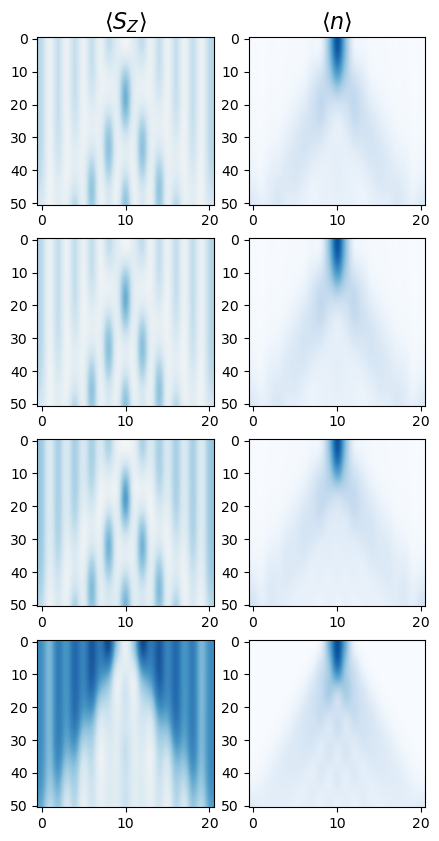

In [512]:
fig,ax = subplots(4,2,figsize=(5,10))
for i = 1:4
    ax[i,1].imshow(real.(scan_U_res_e[2*i-1]),vmin=-maximum(abs.(scan_U_res_e[7])),vmax=maximum(abs.(scan_U_res_e[7]))
                , aspect="auto", cmap="RdBu", interpolation="gaussian")
    ax[i,2].imshow(real.(scan_U_res_e[2*i]),vmin=0.0,vmax=maximum(real.(scan_U_res_e[2]))
                , aspect="auto", cmap="Blues_r", interpolation="gaussian")
end

ax[1,1].set_title(L"$\langle S_Z \rangle$", fontsize=16)
ax[1,2].set_title(L"$\langle n \rangle$", fontsize=16)

gcf()

In [514]:
for i = 1:length(scan_U_res_e[7][:,1])
# i = 1
    fig,ax = subplots(figsize=(10,4))
    # for i = 1:length(scan_U_res_e[8][:,1])
    #     ax.plot(real.(scan_U_res_e[7][i,:]),color="black",label=L"$\langle S_Z \rangle$")
    # end
    ax.plot(real.(scan_U_res_e[8][i,:]),"-o", color="firebrick",label=L"$\langle n \rangle$")
    ax.plot(abs.(scan_U_res_e[7][i,:]),"-o", color="darkblue",label=L"$\langle |S_Z| \rangle$")
    ax.legend(fontsize=16, loc=(1.05,0.5))
    # ax.set_title(L"$t=$"*string(i*dt), fontsize=14)
    props = Dict("boxstyle" => "round", "facecolor" => "white", "alpha" => 1.0)
    ax.text(22.5,0.7,L"$t=$"*string(round(dt,digits=2)),bbox=props,fontsize=16)
    # boxstyle='round', facecolor='wheat', alpha=0.5
    ax.set_ylim([-0.5,1.05])
    ax.set_xticks(0:2:20)
    ax.grid()
    fig.tight_layout()
    fig.savefig("timeevolutionviedo/plot_abs"*string(i)*".png")
end
# gcf()

In [426]:
colormap_name = "viridis"
num_colors = 4
cmap = get_cmap(colormap_name)
colors = [cmap(k/num_colors) for k in 0:num_colors-1]
for i = 1:div(length(scan_U_res_e[7][:,1]),10)
# i = 1
    fig,ax = subplots(2,1,figsize=(10,4))
    # for i = 1:length(scan_U_res_e[8][:,1])
    #     ax.plot(real.(scan_U_res_e[7][i,:]),color="black",label=L"$\langle S_Z \rangle$")
    # end


    ax[1].plot(real.(scan_U_res_e[2][10*i,:]),"-o", color=colors[1])
    ax[1].plot(real.(scan_U_res_e[4][10*i,:]),"-o", color=colors[2])
    ax[1].plot(real.(scan_U_res_e[6][10*i,:]),"-o", color=colors[3])
    ax[1].plot(real.(scan_U_res_e[8][10*i,:]),"-o", color=colors[4])
    ax[2].plot(real.(scan_U_res_e[1][10*i,:]),"-o", color=colors[1],label=Us[1])
    ax[2].plot(real.(scan_U_res_e[3][10*i,:]),"-o", color=colors[2],label=Us[2])
    ax[2].plot(real.(scan_U_res_e[5][10*i,:]),"-o", color=colors[3],label=Us[3])
    ax[2].plot(real.(scan_U_res_e[7][10*i,:]),"-o", color=colors[4],label=Us[4])
    ax[2].legend(fontsize=14, loc=(1.05,0.0), title=L"$U$")
    # ax[2].set_title(L"$t=$"*string(i*dt), fontsize=14)
    props = Dict("boxstyle" => "round", "facecolor" => "white", "alpha" => 1.0)
    ax[1].text(22.5,0.7,L"$t=$"*string(round(10*i*dt,digits=2)),bbox=props,fontsize=16)
    # boxstyle='round', facecolor='wheat', alpha=0.5
    ax[1].set_ylim([0.0,1.05])
    ax[2].set_ylim([-0.5,0.5])
    ax[2].set_xticks(0:2:20)
    ax[1].grid()
    ax[2].grid()

    ax[1].set_ylabel(L"$\langle n \rangle$", fontsize=14)
    ax[2].set_ylabel(L"$\langle S_z \rangle$", fontsize=14)
    fig.tight_layout()
    fig.savefig("timeevolutionviedo/plot_sep"*string(i)*".png")
end
# gcf()

In [359]:
size(scan_U_res_e[7][:,:])

(501, 21)

## Quenching spin

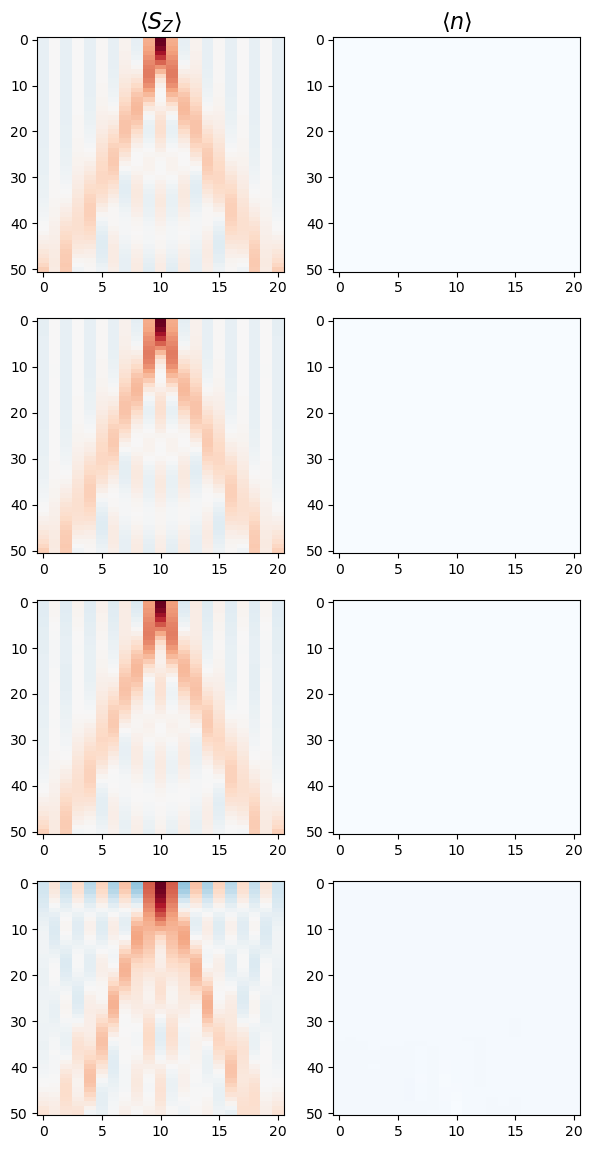

In [230]:
fig,ax = subplots(4,2,figsize=(7,14))
for i = 1:4
    ax[i,1].imshow(real.(scan_U_res_s[2*i-1]),vmin=-maximum(abs.(scan_U_res_s[2*i-1])),vmax=maximum(abs.(scan_U_res_s[2*i-1]))
                , aspect="auto", cmap="RdBu", interpolation="none")
    ax[i,2].imshow(real.(scan_U_res_s[2*i]),vmin=0.0,vmax=maximum(real.(scan_U_res_s[2*i]))
                , aspect="auto", cmap="Blues_r", interpolation="none")
end

ax[1,1].set_title(L"$\langle S_Z \rangle$", fontsize=16)
ax[1,2].set_title(L"$\langle n \rangle$", fontsize=16)


gcf()

In [218]:
scan_U_res_s[1]

51×21 Matrix{ComplexF64}:
   0.041598+0.0im  -0.000308771+0.0im   0.0416676+0.0im  …   0.0415982+0.0im
  0.0415953+0.0im  -0.000309643+0.0im   0.0416631+0.0im      0.0415956+0.0im
  0.0415871+0.0im   -0.00031204+0.0im   0.0416495+0.0im      0.0415876+0.0im
  0.0415734+0.0im  -0.000315986+0.0im   0.0416266+0.0im      0.0415741+0.0im
  0.0415541+0.0im  -0.000321511+0.0im   0.0415942+0.0im      0.0415548+0.0im
  0.0415288+0.0im  -0.000328783+0.0im   0.0415517+0.0im  …   0.0415297+0.0im
  0.0414973+0.0im  -0.000337922+0.0im   0.0414984+0.0im      0.0414984+0.0im
  0.0414593+0.0im  -0.000349056+0.0im   0.0414336+0.0im      0.0414604+0.0im
  0.0414142+0.0im  -0.000362357+0.0im   0.0413559+0.0im      0.0414155+0.0im
  0.0413614+0.0im  -0.000378042+0.0im   0.0412639+0.0im       0.041363+0.0im
           ⋮                                             ⋱            ⋮
 -0.0114288+0.0im    -0.0269483+0.0im  -0.0853257+0.0im     -0.0114461+0.0im
 -0.0203907+0.0im    -0.0303582+0.0im  -0.0956364+0.0im

# $\nu = 1/3$

In [12]:
L = 15
Ne = 10
dt = 1e-1
T = 5.0
Us = [0.0, 0.1, 1.0, 10.0]
state0 = InitialState(L, Ne, 0)
scan_U_res_third = []
for (i,U) in enumerate(Us)
    E, psi = Hubbard_DMRG(L,U,10,50, state0)
    append!(scan_U_res_third,ExpValInTime(Quench(Quench(psi, "Cdn"), "Cup"), E, U, dt, T))
end

filling factor is 0.3333333333333333


After sweep 1 energy=-6.910646914474075  maxlinkdim=6 maxerr=1.11E-15 time=0.048


After sweep 2 energy=-12.427569625043828  maxlinkdim=47 maxerr=8.94E-11 time=0.200


After sweep 3 energy=-15.143929704331816  maxlinkdim=50 maxerr=1.47E-06 time=0.328


After sweep 4 energy=-15.925474342126368  maxlinkdim=50 maxerr=1.37E-05 time=0.407


After sweep 5 energy=-15.994308878480501  maxlinkdim=50 maxerr=1.61E-05 time=0.427


After sweep 6 energy=-15.994979332732136  maxlinkdim=50 maxerr=1.73E-05 time=0.440


After sweep 7 energy=-15.994980519224285  maxlinkdim=50 maxerr=1.59E-05 time=0.478


After sweep 8 energy=-15.994980633060269  maxlinkdim=50 maxerr=1.57E-05 time=0.454


After sweep 9 energy=-15.994980644161771  maxlinkdim=50 maxerr=1.57E-05 time=0.435


After sweep 10 energy=-15.99498064591335  maxlinkdim=50 maxerr=1.57E-05 time=0.431


Norm of quenched wavefunction: 0.6124217838197807
Norm of quenched wavefunction: 0.3750640574188596


 27.075898 seconds (51.56 M allocations: 2.703 GiB, 2.74% gc time, 98.95% compilation time)
maxlinkdim(q_psi) = 43
  0.222883 seconds (1.01 M allocations: 191.720 MiB, 19.74% gc time)


maxlinkdim(q_psi) = 43


  0.255102 seconds (1.01 M allocations: 191.388 MiB, 29.80% gc time)
maxlinkdim(q_psi) = 43
  0.206835 seconds (1.01 M allocations: 191.388 MiB, 14.87% gc time)


maxlinkdim(q_psi) = 43


  0.203771 seconds (1.01 M allocations: 191.388 MiB, 14.27% gc time)
maxlinkdim(q_psi) = 43
  0.200513 seconds (1.01 M allocations: 191.388 MiB, 15.20% gc time)


maxlinkdim(q_psi) = 43


  0.204494 seconds (1.01 M allocations: 191.388 MiB, 14.37% gc time)
maxlinkdim(q_psi) = 43
  0.199101 seconds (1.01 M allocations: 191.388 MiB, 14.75% gc time)


maxlinkdim(q_psi) = 43


  0.207502 seconds (1.01 M allocations: 191.388 MiB, 14.61% gc time)
maxlinkdim(q_psi) = 43
  0.204876 seconds (1.01 M allocations: 191.388 MiB, 15.65% gc time)


maxlinkdim(q_psi) = 43


  0.204475 seconds (1.01 M allocations: 191.388 MiB, 14.68% gc time)
maxlinkdim(q_psi) = 43
  0.201971 seconds (1.01 M allocations: 191.388 MiB, 14.70% gc time)


maxlinkdim(q_psi) = 43


  0.224559 seconds (1.01 M allocations: 191.388 MiB, 14.17% gc time)
maxlinkdim(q_psi) = 43
  0.197993 seconds (1.01 M allocations: 191.388 MiB, 13.57% gc time)


maxlinkdim(q_psi) = 43


  0.204940 seconds (1.01 M allocations: 191.388 MiB, 14.95% gc time)
maxlinkdim(q_psi) = 43
  0.207073 seconds (1.01 M allocations: 191.388 MiB, 16.18% gc time)


maxlinkdim(q_psi) = 43


  0.209956 seconds (1.01 M allocations: 191.388 MiB, 15.55% gc time)
maxlinkdim(q_psi) = 43
  0.198642 seconds (1.01 M allocations: 191.388 MiB, 14.26% gc time)


maxlinkdim(q_psi) = 43


  0.203156 seconds (1.01 M allocations: 191.388 MiB, 14.13% gc time)
maxlinkdim(q_psi) = 43
  0.228960 seconds (1.01 M allocations: 191.388 MiB, 25.81% gc time)


maxlinkdim(q_psi) = 43


  0.201150 seconds (1.01 M allocations: 191.388 MiB, 13.78% gc time)
maxlinkdim(q_psi) = 43
  0.225744 seconds (1.01 M allocations: 191.388 MiB, 24.47% gc time)


maxlinkdim(q_psi) = 43


  0.205466 seconds (1.01 M allocations: 191.388 MiB, 14.87% gc time)
maxlinkdim(q_psi) = 43
  0.251251 seconds (1.01 M allocations: 191.388 MiB, 25.74% gc time)


maxlinkdim(q_psi) = 43


  0.202774 seconds (1.01 M allocations: 191.388 MiB, 14.17% gc time)
maxlinkdim(q_psi) = 43
  0.237231 seconds (1.01 M allocations: 191.388 MiB, 25.40% gc time)


maxlinkdim(q_psi) = 43


  0.202806 seconds (1.01 M allocations: 191.388 MiB, 14.45% gc time)
maxlinkdim(q_psi) = 43
  0.300276 seconds (1.01 M allocations: 191.388 MiB, 21.75% gc time)


maxlinkdim(q_psi) = 43


  0.211766 seconds (1.01 M allocations: 191.388 MiB, 14.64% gc time)
maxlinkdim(q_psi) = 43
  0.290398 seconds (1.01 M allocations: 191.388 MiB, 21.71% gc time)


maxlinkdim(q_psi) = 43


  0.223761 seconds (1.01 M allocations: 191.388 MiB, 11.81% gc time)
maxlinkdim(q_psi) = 43
  0.257505 seconds (1.01 M allocations: 191.388 MiB, 24.45% gc time)


maxlinkdim(q_psi) = 43


  0.247330 seconds (1.01 M allocations: 191.388 MiB, 12.31% gc time)
maxlinkdim(q_psi) = 43
  0.247508 seconds (1.01 M allocations: 191.388 MiB, 24.37% gc time)


maxlinkdim(q_psi) = 43


  0.220187 seconds (1.01 M allocations: 191.388 MiB, 13.87% gc time)
maxlinkdim(q_psi) = 43
  0.223188 seconds (1.01 M allocations: 191.388 MiB, 14.24% gc time)


maxlinkdim(q_psi) = 43


  0.216135 seconds (1.01 M allocations: 191.388 MiB, 12.55% gc time)
maxlinkdim(q_psi) = 43
  0.216513 seconds (1.01 M allocations: 191.388 MiB, 13.65% gc time)


maxlinkdim(q_psi) = 43


  0.216739 seconds (1.01 M allocations: 191.388 MiB, 13.84% gc time)
maxlinkdim(q_psi) = 43
  0.211097 seconds (1.01 M allocations: 191.388 MiB, 12.97% gc time)


maxlinkdim(q_psi) = 43


  0.211438 seconds (1.01 M allocations: 191.388 MiB, 14.73% gc time)
maxlinkdim(q_psi) = 43
  0.210224 seconds (1.01 M allocations: 191.484 MiB, 13.14% gc time)


maxlinkdim(q_psi) = 43


  0.252750 seconds (1.01 M allocations: 191.484 MiB, 12.33% gc time)
maxlinkdim(q_psi) = 43
  0.209309 seconds (1.01 M allocations: 191.484 MiB, 14.12% gc time)


maxlinkdim(q_psi) = 43


  0.210505 seconds (1.01 M allocations: 191.484 MiB, 15.30% gc time)
maxlinkdim(q_psi) = 43
  0.207015 seconds (1.01 M allocations: 191.484 MiB, 12.83% gc time)


maxlinkdim(q_psi) = 43


  0.240194 seconds (1.01 M allocations: 191.484 MiB, 25.72% gc time)
maxlinkdim(q_psi) = 43
  0.210307 seconds (1.01 M allocations: 191.484 MiB, 14.38% gc time)


maxlinkdim(q_psi) = 43


  0.236502 seconds (1.01 M allocations: 191.484 MiB, 24.82% gc time)
maxlinkdim(q_psi) = 43
  0.209248 seconds (1.01 M allocations: 191.484 MiB, 13.93% gc time)


maxlinkdim(q_psi) = 43


  0.239974 seconds (1.01 M allocations: 191.484 MiB, 25.03% gc time)
maxlinkdim(q_psi) = 43
  0.212348 seconds (1.01 M allocations: 191.484 MiB, 15.61% gc time)


maxlinkdim(q_psi) = 43


  0.240855 seconds (1.01 M allocations: 191.484 MiB, 25.59% gc time)
maxlinkdim(q_psi) = 43
  0.211919 seconds (1.01 M allocations: 191.484 MiB, 15.37% gc time)


maxlinkdim(q_psi) = 43


  0.241895 seconds (1.01 M allocations: 191.484 MiB, 25.45% gc time)
maxlinkdim(q_psi) = 43
  0.209707 seconds (1.01 M allocations: 191.484 MiB, 14.08% gc time)


maxlinkdim(q_psi) = 43


  0.237638 seconds (1.01 M allocations: 191.484 MiB, 24.35% gc time)
maxlinkdim(q_psi) = 43
  0.208589 seconds (1.01 M allocations: 191.484 MiB, 14.56% gc time)


maxlinkdim(q_psi) = 43


  0.237127 seconds (1.01 M allocations: 191.484 MiB, 23.81% gc time)
maxlinkdim(q_psi) = 43
  0.208262 seconds (1.01 M allocations: 191.484 MiB, 14.61% gc time)


maxlinkdim(q_psi) = 43


  0.215296 seconds (1.01 M allocations: 191.484 MiB, 15.25% gc time)
maxlinkdim(q_psi) = 43
  0.203544 seconds (1.01 M allocations: 191.484 MiB, 12.87% gc time)


maxlinkdim(q_psi) = 43


  0.215032 seconds (1.01 M allocations: 191.484 MiB, 14.37% gc time)
maxlinkdim(q_psi) = 43
  0.208715 seconds (1.01 M allocations: 191.569 MiB, 14.14% gc time)


maxlinkdim(q_psi) = 43


  0.206411 seconds (1.01 M allocations: 191.659 MiB, 13.11% gc time)
maxlinkdim(q_psi) = 43
  0.208256 seconds (1.01 M allocations: 191.659 MiB, 13.85% gc time)


maxlinkdim(q_psi) = 43


  0.211081 seconds (1.01 M allocations: 191.659 MiB, 14.89% gc time)
maxlinkdim(q_psi) = 43
  0.209161 seconds (1.01 M allocations: 191.659 MiB, 13.95% gc time)


maxlinkdim(q_psi) = 43


  0.210150 seconds (1.01 M allocations: 191.659 MiB, 13.87% gc time)
maxlinkdim(q_psi) = 43
  0.240179 seconds (1.01 M allocations: 191.659 MiB, 24.21% gc time)


maxlinkdim(q_psi) = 43


  0.208509 seconds (1.01 M allocations: 191.659 MiB, 13.82% gc time)
maxlinkdim(q_psi) = 43
  0.239358 seconds (1.01 M allocations: 191.659 MiB, 25.54% gc time)


maxlinkdim(q_psi) = 43


  0.211097 seconds (1.01 M allocations: 191.659 MiB, 14.60% gc time)
maxlinkdim(q_psi) = 43
  0.243361 seconds (1.01 M allocations: 191.659 MiB, 25.64% gc time)


maxlinkdim(q_psi) = 43


  0.215013 seconds (1.01 M allocations: 191.659 MiB, 13.78% gc time)
maxlinkdim(q_psi) = 43
  0.241585 seconds (1.01 M allocations: 191.659 MiB, 24.40% gc time)


maxlinkdim(q_psi) = 43


  0.213018 seconds (1.01 M allocations: 191.659 MiB, 12.64% gc time)
maxlinkdim(q_psi) = 43
  0.247920 seconds (1.01 M allocations: 191.659 MiB, 24.97% gc time)


maxlinkdim(q_psi) = 43


  0.216563 seconds (1.01 M allocations: 191.659 MiB, 13.90% gc time)
maxlinkdim(q_psi) = 43
  0.244199 seconds (1.01 M allocations: 191.659 MiB, 23.84% gc time)


maxlinkdim(q_psi) = 43


  0.217792 seconds (1.01 M allocations: 191.659 MiB, 14.52% gc time)
maxlinkdim(q_psi) = 43
  0.213631 seconds (1.01 M allocations: 191.659 MiB, 13.84% gc time)


maxlinkdim(q_psi) = 43


  0.211345 seconds (1.01 M allocations: 191.659 MiB, 13.87% gc time)
maxlinkdim(q_psi) = 43
  0.211623 seconds (1.01 M allocations: 191.659 MiB, 14.79% gc time)


maxlinkdim(q_psi) = 43


  0.205889 seconds (1.01 M allocations: 191.659 MiB, 14.07% gc time)
maxlinkdim(q_psi) = 43
  0.210692 seconds (1.01 M allocations: 191.820 MiB, 15.45% gc time)


maxlinkdim(q_psi) = 43


  0.211578 seconds (1.01 M allocations: 191.569 MiB, 14.16% gc time)
maxlinkdim(q_psi) = 43
  0.205362 seconds (1.01 M allocations: 191.820 MiB, 12.80% gc time)


maxlinkdim(q_psi) = 43


  0.208224 seconds (1.01 M allocations: 191.569 MiB, 14.15% gc time)
maxlinkdim(q_psi) = 43
  0.216621 seconds (1.01 M allocations: 191.820 MiB, 13.78% gc time)


maxlinkdim(q_psi) = 43


  0.241346 seconds (1.01 M allocations: 191.569 MiB, 25.50% gc time)
maxlinkdim(q_psi) = 43
  0.210194 seconds (1.01 M allocations: 191.820 MiB, 14.13% gc time)


maxlinkdim(q_psi) = 43


  0.233071 seconds (1.01 M allocations: 191.569 MiB, 24.57% gc time)
maxlinkdim(q_psi) = 43
  0.212942 seconds (1.01 M allocations: 191.820 MiB, 15.18% gc time)


maxlinkdim(q_psi) = 43


  0.239239 seconds (1.01 M allocations: 191.569 MiB, 24.63% gc time)
maxlinkdim(q_psi) = 43
  0.210204 seconds (1.01 M allocations: 191.820 MiB, 14.07% gc time)


maxlinkdim(q_psi) = 43


  0.238349 seconds (1.01 M allocations: 191.569 MiB, 24.45% gc time)
maxlinkdim(q_psi) = 43
  0.209057 seconds (1.01 M allocations: 191.820 MiB, 14.29% gc time)


maxlinkdim(q_psi) = 43


  0.238700 seconds (1.01 M allocations: 191.569 MiB, 23.98% gc time)
maxlinkdim(q_psi) = 43
  0.207420 seconds (1.01 M allocations: 191.820 MiB, 13.96% gc time)


maxlinkdim(q_psi) = 43


  0.211578 seconds (1.01 M allocations: 191.730 MiB, 12.41% gc time)
maxlinkdim(q_psi) = 43
  0.213580 seconds (1.01 M allocations: 191.730 MiB, 14.98% gc time)


maxlinkdim(q_psi) = 43


  0.216354 seconds (1.01 M allocations: 191.814 MiB, 14.33% gc time)
maxlinkdim(q_psi) = 43
  0.212455 seconds (1.01 M allocations: 191.905 MiB, 13.47% gc time)


maxlinkdim(q_psi) = 43


  0.215106 seconds (1.01 M allocations: 191.905 MiB, 13.47% gc time)
maxlinkdim(q_psi) = 43
  0.215632 seconds (1.01 M allocations: 191.905 MiB, 14.46% gc time)


maxlinkdim(q_psi) = 43


  0.214656 seconds (1.01 M allocations: 191.905 MiB, 14.03% gc time)
maxlinkdim(q_psi) = 43
  0.211082 seconds (1.01 M allocations: 191.905 MiB, 13.76% gc time)


maxlinkdim(q_psi) = 43


  0.212177 seconds (1.01 M allocations: 191.905 MiB, 12.57% gc time)
maxlinkdim(q_psi) = 43
  0.243270 seconds (1.01 M allocations: 191.905 MiB, 25.10% gc time)


maxlinkdim(q_psi) = 43


  0.217657 seconds (1.01 M allocations: 191.905 MiB, 14.18% gc time)
maxlinkdim(q_psi) = 43
  0.245562 seconds (1.01 M allocations: 191.905 MiB, 24.69% gc time)


maxlinkdim(q_psi) = 43


  0.215980 seconds (1.01 M allocations: 191.905 MiB, 14.80% gc time)
maxlinkdim(q_psi) = 43
  0.238021 seconds (1.01 M allocations: 191.905 MiB, 23.77% gc time)


maxlinkdim(q_psi) = 43


  0.211563 seconds (1.01 M allocations: 191.905 MiB, 14.04% gc time)
maxlinkdim(q_psi) = 43
  0.237568 seconds (1.01 M allocations: 191.979 MiB, 24.61% gc time)


maxlinkdim(q_psi) = 43


  0.211861 seconds (1.01 M allocations: 191.979 MiB, 14.02% gc time)
maxlinkdim(q_psi) = 43
  0.212183 seconds (1.01 M allocations: 191.979 MiB, 13.34% gc time)


maxlinkdim(q_psi) = 43


  0.206286 seconds (1.01 M allocations: 191.979 MiB, 12.60% gc time)
maxlinkdim(q_psi) = 43
  0.207964 seconds (1.01 M allocations: 191.979 MiB, 13.87% gc time)


maxlinkdim(q_psi) = 43


  0.207019 seconds (1.01 M allocations: 191.979 MiB, 13.85% gc time)
maxlinkdim(q_psi) = 43
  0.210141 seconds (1.01 M allocations: 191.979 MiB, 13.56% gc time)


maxlinkdim(q_psi) = 43


  0.209409 seconds (1.01 M allocations: 191.979 MiB, 14.76% gc time)
maxlinkdim(q_psi) = 43
  0.208193 seconds (1.01 M allocations: 191.979 MiB, 13.21% gc time)


maxlinkdim(q_psi) = 43


  0.225998 seconds (1.01 M allocations: 191.979 MiB, 12.03% gc time)
maxlinkdim(q_psi) = 43
  0.216704 seconds (1.01 M allocations: 191.979 MiB, 14.02% gc time)


maxlinkdim(q_psi) = 43


  0.244499 seconds (1.01 M allocations: 191.979 MiB, 25.44% gc time)
maxlinkdim(q_psi) = 43
  0.214054 seconds (1.01 M allocations: 191.979 MiB, 13.89% gc time)


maxlinkdim(q_psi) = 43


  0.241842 seconds (1.01 M allocations: 192.181 MiB, 24.20% gc time)
maxlinkdim(q_psi) = 43
  0.214283 seconds (1.01 M allocations: 192.621 MiB, 14.14% gc time)


maxlinkdim(q_psi) = 43


  0.246721 seconds (1.01 M allocations: 192.621 MiB, 24.65% gc time)
maxlinkdim(q_psi) = 43
  0.213263 seconds (1.01 M allocations: 192.621 MiB, 14.09% gc time)


maxlinkdim(q_psi) = 43


  0.244187 seconds (1.01 M allocations: 192.621 MiB, 25.24% gc time)
maxlinkdim(q_psi) = 43
  0.214120 seconds (1.01 M allocations: 192.621 MiB, 14.04% gc time)


maxlinkdim(q_psi) = 43


  0.213518 seconds (1.01 M allocations: 192.621 MiB, 13.78% gc time)
maxlinkdim(q_psi) = 43
  0.210662 seconds (1.01 M allocations: 192.621 MiB, 13.61% gc time)


maxlinkdim(q_psi) = 43


  0.228254 seconds (1.01 M allocations: 192.621 MiB, 12.92% gc time)
maxlinkdim(q_psi) = 43
  0.215548 seconds (1.01 M allocations: 192.621 MiB, 14.92% gc time)


maxlinkdim(q_psi) = 43


  0.216646 seconds (1.01 M allocations: 192.621 MiB, 14.38% gc time)
maxlinkdim(q_psi) = 43
  0.207550 seconds (1.01 M allocations: 192.621 MiB, 12.79% gc time)


maxlinkdim(q_psi) = 43


  0.315660 seconds (1.01 M allocations: 192.621 MiB, 8.68% gc time)
maxlinkdim(q_psi) = 43
  0.214334 seconds (1.01 M allocations: 192.866 MiB, 12.57% gc time)


maxlinkdim(q_psi) = 43


  0.217264 seconds (1.01 M allocations: 192.866 MiB, 14.81% gc time)
maxlinkdim(q_psi) = 43
  0.240608 seconds (1.01 M allocations: 192.866 MiB, 25.13% gc time)


maxlinkdim(q_psi) = 43


  0.210671 seconds (1.01 M allocations: 192.866 MiB, 14.16% gc time)
maxlinkdim(q_psi) = 43
  0.240403 seconds (1.01 M allocations: 192.866 MiB, 25.22% gc time)


maxlinkdim(q_psi) = 43


  0.211692 seconds (1.01 M allocations: 192.866 MiB, 14.89% gc time)
maxlinkdim(q_psi) = 43
  0.240356 seconds (1.01 M allocations: 192.866 MiB, 25.17% gc time)


maxlinkdim(q_psi) = 43


  0.211000 seconds (1.01 M allocations: 192.866 MiB, 13.08% gc time)
maxlinkdim(q_psi) = 43
  0.238178 seconds (1.01 M allocations: 192.866 MiB, 24.59% gc time)


maxlinkdim(q_psi) = 43


  0.211442 seconds (1.01 M allocations: 192.866 MiB, 13.47% gc time)
maxlinkdim(q_psi) = 43
  0.234260 seconds (1.02 M allocations: 193.527 MiB, 23.89% gc time)


maxlinkdim(q_psi) = 43


  0.214515 seconds (1.02 M allocations: 193.527 MiB, 14.83% gc time)
maxlinkdim(q_psi) = 43
  0.212074 seconds (1.02 M allocations: 193.529 MiB, 14.86% gc time)


maxlinkdim(q_psi) = 43


  0.210766 seconds (1.02 M allocations: 193.620 MiB, 14.71% gc time)
maxlinkdim(q_psi) = 43
  0.216111 seconds (1.02 M allocations: 193.620 MiB, 15.22% gc time)


maxlinkdim(q_psi) = 43


  0.215839 seconds (1.02 M allocations: 193.620 MiB, 12.70% gc time)
maxlinkdim(q_psi) = 43
  0.219200 seconds (1.02 M allocations: 193.618 MiB, 14.78% gc time)


maxlinkdim(q_psi) = 43


  0.214877 seconds (1.02 M allocations: 193.712 MiB, 14.69% gc time)
maxlinkdim(q_psi) = 43
  0.213321 seconds (1.02 M allocations: 193.712 MiB, 14.03% gc time)


maxlinkdim(q_psi) = 43


  0.216495 seconds (1.02 M allocations: 193.712 MiB, 14.55% gc time)
maxlinkdim(q_psi) = 43
  0.212382 seconds (1.02 M allocations: 193.712 MiB, 12.98% gc time)


maxlinkdim(q_psi) = 43


  0.214778 seconds (1.02 M allocations: 193.715 MiB, 14.33% gc time)
maxlinkdim(q_psi) = 43
  0.218015 seconds (1.02 M allocations: 193.715 MiB, 15.23% gc time)


maxlinkdim(q_psi) = 43


  0.246932 seconds (1.02 M allocations: 193.715 MiB, 25.24% gc time)
maxlinkdim(q_psi) = 43
  0.218044 seconds (1.02 M allocations: 193.715 MiB, 14.35% gc time)


maxlinkdim(q_psi) = 43


  0.246673 seconds (1.02 M allocations: 193.715 MiB, 25.48% gc time)
maxlinkdim(q_psi) = 43
  0.218709 seconds (1.02 M allocations: 194.271 MiB, 14.75% gc time)


maxlinkdim(q_psi) = 43


  0.243820 seconds (1.02 M allocations: 194.836 MiB, 24.14% gc time)
maxlinkdim(q_psi) = 43
  0.215360 seconds (1.02 M allocations: 194.490 MiB, 13.32% gc time)


maxlinkdim(q_psi) = 43


  0.250105 seconds (1.02 M allocations: 195.071 MiB, 24.81% gc time)
maxlinkdim(q_psi) = 43
  0.222269 seconds (1.02 M allocations: 194.490 MiB, 12.99% gc time)


maxlinkdim(q_psi) = 43


  0.249341 seconds (1.03 M allocations: 195.709 MiB, 23.06% gc time)
maxlinkdim(q_psi) = 43
  0.209224 seconds (1.03 M allocations: 195.474 MiB, 12.77% gc time)


maxlinkdim(q_psi) = 43


  0.245955 seconds (1.03 M allocations: 195.474 MiB, 24.80% gc time)
maxlinkdim(q_psi) = 43
  0.211653 seconds (1.03 M allocations: 195.474 MiB, 13.60% gc time)


maxlinkdim(q_psi) = 43


  0.246979 seconds (1.03 M allocations: 195.474 MiB, 24.81% gc time)
maxlinkdim(q_psi) = 43
  0.217675 seconds (1.03 M allocations: 195.474 MiB, 13.39% gc time)


maxlinkdim(q_psi) = 43


  0.215172 seconds (1.03 M allocations: 195.474 MiB, 14.52% gc time)
maxlinkdim(q_psi) = 43
  0.209682 seconds (1.03 M allocations: 195.474 MiB, 14.36% gc time)


maxlinkdim(q_psi) = 43


  0.214086 seconds (1.03 M allocations: 195.474 MiB, 13.39% gc time)
maxlinkdim(q_psi) = 43
  0.221615 seconds (1.03 M allocations: 195.817 MiB, 15.28% gc time)


maxlinkdim(q_psi) = 43


  0.218815 seconds (1.03 M allocations: 195.907 MiB, 14.27% gc time)
maxlinkdim(q_psi) = 43
  0.216554 seconds (1.03 M allocations: 195.907 MiB, 14.93% gc time)


maxlinkdim(q_psi) = 43


  0.216415 seconds (1.03 M allocations: 195.907 MiB, 12.99% gc time)
maxlinkdim(q_psi) = 43
  0.218471 seconds (1.03 M allocations: 195.907 MiB, 14.75% gc time)


maxlinkdim(q_psi) = 43


  0.221779 seconds (1.03 M allocations: 195.907 MiB, 14.62% gc time)
maxlinkdim(q_psi) = 43
  0.212977 seconds (1.03 M allocations: 195.907 MiB, 12.92% gc time)


maxlinkdim(q_psi) = 43


  0.216723 seconds (1.03 M allocations: 195.907 MiB, 12.89% gc time)
maxlinkdim(q_psi) = 43
  0.214547 seconds (1.03 M allocations: 195.907 MiB, 13.27% gc time)


maxlinkdim(q_psi) = 43


  0.221813 seconds (1.03 M allocations: 196.125 MiB, 14.34% gc time)
maxlinkdim(q_psi) = 43
  0.217701 seconds (1.03 M allocations: 195.817 MiB, 13.84% gc time)


maxlinkdim(q_psi) = 43


  0.219131 seconds (1.03 M allocations: 196.125 MiB, 12.15% gc time)
maxlinkdim(q_psi) = 43
  0.214989 seconds (1.03 M allocations: 195.817 MiB, 13.77% gc time)


maxlinkdim(q_psi) = 43


  0.219367 seconds (1.03 M allocations: 196.125 MiB, 13.75% gc time)
maxlinkdim(q_psi) = 43
  0.219793 seconds (1.03 M allocations: 195.817 MiB, 14.14% gc time)


maxlinkdim(q_psi) = 43


  0.221036 seconds (1.03 M allocations: 196.125 MiB, 13.31% gc time)
maxlinkdim(q_psi) = 43
  0.251472 seconds (1.03 M allocations: 196.036 MiB, 26.14% gc time)


maxlinkdim(q_psi) = 43


  0.216201 seconds (1.03 M allocations: 196.471 MiB, 13.69% gc time)
maxlinkdim(q_psi) = 43
  0.237656 seconds (1.03 M allocations: 196.706 MiB, 23.12% gc time)


maxlinkdim(q_psi) = 43


  0.214966 seconds (1.03 M allocations: 196.706 MiB, 13.52% gc time)
maxlinkdim(q_psi) = 43
  0.237573 seconds (1.03 M allocations: 196.706 MiB, 23.60% gc time)


maxlinkdim(q_psi) = 43


  0.215959 seconds (1.03 M allocations: 196.706 MiB, 12.80% gc time)
maxlinkdim(q_psi) = 43
  0.245212 seconds (1.03 M allocations: 196.706 MiB, 26.28% gc time)


maxlinkdim(q_psi) = 43


  0.216015 seconds (1.03 M allocations: 196.709 MiB, 13.74% gc time)
maxlinkdim(q_psi) = 43
  0.242762 seconds (1.03 M allocations: 197.370 MiB, 24.93% gc time)


maxlinkdim(q_psi) = 43


  0.215571 seconds (1.03 M allocations: 197.370 MiB, 13.78% gc time)
maxlinkdim(q_psi) = 43
  0.252719 seconds (1.03 M allocations: 197.412 MiB, 26.87% gc time)


maxlinkdim(q_psi) = 43


  0.216944 seconds (1.04 M allocations: 198.098 MiB, 13.29% gc time)
maxlinkdim(q_psi) = 43
  0.248673 seconds (1.04 M allocations: 198.098 MiB, 24.62% gc time)


maxlinkdim(q_psi) = 43


  0.223724 seconds (1.04 M allocations: 198.098 MiB, 14.45% gc time)
maxlinkdim(q_psi) = 43
  0.247751 seconds (1.04 M allocations: 198.098 MiB, 24.17% gc time)


maxlinkdim(q_psi) = 43


  0.220400 seconds (1.04 M allocations: 198.111 MiB, 13.56% gc time)
maxlinkdim(q_psi) = 43
  0.249680 seconds (1.04 M allocations: 198.346 MiB, 24.06% gc time)


maxlinkdim(q_psi) = 43


  0.223394 seconds (1.04 M allocations: 198.346 MiB, 13.82% gc time)
maxlinkdim(q_psi) = 43
  0.243500 seconds (1.04 M allocations: 198.346 MiB, 22.75% gc time)


maxlinkdim(q_psi) = 43


  0.226591 seconds (1.04 M allocations: 198.346 MiB, 14.78% gc time)
maxlinkdim(q_psi) = 43
  0.249260 seconds (1.04 M allocations: 198.806 MiB, 24.58% gc time)


maxlinkdim(q_psi) = 43


  0.221608 seconds (1.04 M allocations: 199.137 MiB, 13.25% gc time)
maxlinkdim(q_psi) = 43
  0.252960 seconds (1.04 M allocations: 198.887 MiB, 25.62% gc time)


maxlinkdim(q_psi) = 43


  0.223019 seconds (1.04 M allocations: 199.617 MiB, 14.68% gc time)
maxlinkdim(q_psi) = 43
  0.249184 seconds (1.04 M allocations: 199.617 MiB, 24.42% gc time)


maxlinkdim(q_psi) = 43


  0.220633 seconds (1.04 M allocations: 199.617 MiB, 13.66% gc time)
maxlinkdim(q_psi) = 43
  0.249778 seconds (1.04 M allocations: 199.894 MiB, 24.73% gc time)


maxlinkdim(q_psi) = 43


  0.221072 seconds (1.04 M allocations: 200.492 MiB, 14.15% gc time)
maxlinkdim(q_psi) = 43
  0.243409 seconds (1.04 M allocations: 200.591 MiB, 24.35% gc time)


maxlinkdim(q_psi) = 43


  0.215969 seconds (1.04 M allocations: 200.796 MiB, 13.26% gc time)
maxlinkdim(q_psi) = 43
  0.246349 seconds (1.04 M allocations: 200.796 MiB, 23.91% gc time)


maxlinkdim(q_psi) = 43


  0.219095 seconds (1.04 M allocations: 200.796 MiB, 13.64% gc time)
maxlinkdim(q_psi) = 43
  0.232967 seconds (1.04 M allocations: 200.796 MiB, 11.95% gc time)


maxlinkdim(q_psi) = 43


  0.220756 seconds (1.04 M allocations: 201.016 MiB, 13.33% gc time)
maxlinkdim(q_psi) = 43
  0.217692 seconds (1.04 M allocations: 201.553 MiB, 12.88% gc time)


maxlinkdim(q_psi) = 43


  0.329678 seconds (1.04 M allocations: 201.555 MiB, 9.65% gc time)
maxlinkdim(q_psi) = 43
  0.231165 seconds (1.04 M allocations: 202.122 MiB, 13.09% gc time)


maxlinkdim(q_psi) = 44


  0.230755 seconds (1.05 M allocations: 202.764 MiB, 13.81% gc time)
maxlinkdim(q_psi) = 44
  0.228114 seconds (1.05 M allocations: 202.764 MiB, 14.96% gc time)


maxlinkdim(q_psi) = 44


  0.228266 seconds (1.05 M allocations: 202.764 MiB, 12.15% gc time)
maxlinkdim(q_psi) = 44
  0.223885 seconds (1.05 M allocations: 202.850 MiB, 14.45% gc time)


maxlinkdim(q_psi) = 44


  0.266509 seconds (1.05 M allocations: 202.850 MiB, 23.89% gc time)
maxlinkdim(q_psi) = 44
  0.233404 seconds (1.05 M allocations: 203.121 MiB, 13.44% gc time)


maxlinkdim(q_psi) = 44


  0.258004 seconds (1.05 M allocations: 203.367 MiB, 23.61% gc time)
maxlinkdim(q_psi) = 44
  0.222336 seconds (1.05 M allocations: 203.367 MiB, 13.40% gc time)


maxlinkdim(q_psi) = 44


  0.259414 seconds (1.05 M allocations: 203.618 MiB, 24.48% gc time)
maxlinkdim(q_psi) = 44
  0.225576 seconds (1.05 M allocations: 204.180 MiB, 13.16% gc time)


maxlinkdim(q_psi) = 44


  0.255951 seconds (1.05 M allocations: 204.180 MiB, 24.30% gc time)
maxlinkdim(q_psi) = 44
  0.232324 seconds (1.05 M allocations: 204.180 MiB, 14.11% gc time)


maxlinkdim(q_psi) = 44


  0.224348 seconds (1.05 M allocations: 204.180 MiB, 12.74% gc time)
maxlinkdim(q_psi) = 44
  0.226756 seconds (1.05 M allocations: 204.180 MiB, 13.32% gc time)


maxlinkdim(q_psi) = 44


  0.222620 seconds (1.05 M allocations: 204.390 MiB, 12.95% gc time)
maxlinkdim(q_psi) = 44
  0.228691 seconds (1.05 M allocations: 204.805 MiB, 14.33% gc time)


maxlinkdim(q_psi) = 44


  0.225974 seconds (1.05 M allocations: 204.885 MiB, 13.55% gc time)
maxlinkdim(q_psi) = 44
  0.253563 seconds (1.05 M allocations: 205.655 MiB, 23.40% gc time)


maxlinkdim(q_psi) = 44


  0.227578 seconds (1.05 M allocations: 205.973 MiB, 12.97% gc time)
maxlinkdim(q_psi) = 44
  0.247975 seconds (1.05 M allocations: 206.428 MiB, 22.11% gc time)


maxlinkdim(q_psi) = 44


  0.223306 seconds (1.05 M allocations: 206.428 MiB, 13.00% gc time)
maxlinkdim(q_psi) = 44
  0.252530 seconds (1.05 M allocations: 206.428 MiB, 23.98% gc time)


maxlinkdim(q_psi) = 44


  0.232627 seconds (1.06 M allocations: 207.127 MiB, 15.04% gc time)
maxlinkdim(q_psi) = 44
  0.227008 seconds (1.06 M allocations: 207.275 MiB, 14.27% gc time)


maxlinkdim(q_psi) = 44


  0.229418 seconds (1.06 M allocations: 207.275 MiB, 12.70% gc time)
maxlinkdim(q_psi) = 44
  0.221700 seconds (1.06 M allocations: 207.366 MiB, 12.72% gc time)


maxlinkdim(q_psi) = 45


  0.258237 seconds (1.06 M allocations: 208.157 MiB, 24.02% gc time)
maxlinkdim(q_psi) = 44
  0.227226 seconds (1.06 M allocations: 207.853 MiB, 12.59% gc time)


maxlinkdim(q_psi) = 45


  0.262457 seconds (1.06 M allocations: 208.245 MiB, 24.12% gc time)
maxlinkdim(q_psi) = 45
  0.243616 seconds (1.06 M allocations: 208.257 MiB, 13.92% gc time)


maxlinkdim(q_psi) = 45


  0.264990 seconds (1.06 M allocations: 208.648 MiB, 24.41% gc time)
maxlinkdim(q_psi) = 45
  0.232899 seconds (1.06 M allocations: 209.106 MiB, 13.17% gc time)


maxlinkdim(q_psi) = 45


  0.225951 seconds (1.06 M allocations: 209.106 MiB, 12.63% gc time)
maxlinkdim(q_psi) = 45
  0.264193 seconds (1.06 M allocations: 209.107 MiB, 24.55% gc time)


maxlinkdim(q_psi) = 45


  0.234161 seconds (1.06 M allocations: 209.118 MiB, 12.73% gc time)
maxlinkdim(q_psi) = 45
  0.272150 seconds (1.06 M allocations: 209.803 MiB, 22.72% gc time)


maxlinkdim(q_psi) = 45


  0.245174 seconds (1.06 M allocations: 209.803 MiB, 13.46% gc time)
maxlinkdim(q_psi) = 45
  0.268837 seconds (1.06 M allocations: 209.803 MiB, 24.87% gc time)


maxlinkdim(q_psi) = 45


  0.239132 seconds (1.06 M allocations: 209.803 MiB, 12.34% gc time)
maxlinkdim(q_psi) = 45
  0.244250 seconds (1.06 M allocations: 209.878 MiB, 14.88% gc time)


maxlinkdim(q_psi) = 45


  0.278832 seconds (1.06 M allocations: 210.140 MiB, 24.30% gc time)
maxlinkdim(q_psi) = 45
  0.240198 seconds (1.06 M allocations: 210.411 MiB, 14.44% gc time)


maxlinkdim(q_psi) = 48


  0.271057 seconds (1.06 M allocations: 211.124 MiB, 22.96% gc time)
maxlinkdim(q_psi) = 45
  0.234503 seconds (1.06 M allocations: 211.070 MiB, 12.59% gc time)


maxlinkdim(q_psi) = 48


  0.232403 seconds (1.06 M allocations: 211.124 MiB, 13.03% gc time)
maxlinkdim(q_psi) = 45
  0.234176 seconds (1.06 M allocations: 210.937 MiB, 12.15% gc time)


maxlinkdim(q_psi) = 48


  0.234511 seconds (1.06 M allocations: 211.512 MiB, 13.02% gc time)
maxlinkdim(q_psi) = 48
  0.260922 seconds (1.06 M allocations: 211.512 MiB, 22.26% gc time)


maxlinkdim(q_psi) = 48


  0.235266 seconds (1.06 M allocations: 211.609 MiB, 12.88% gc time)
maxlinkdim(q_psi) = 48
  0.268448 seconds (1.06 M allocations: 211.609 MiB, 24.85% gc time)


maxlinkdim(q_psi) = 48


  0.233765 seconds (1.06 M allocations: 211.609 MiB, 12.57% gc time)
maxlinkdim(q_psi) = 48
  0.235822 seconds (1.06 M allocations: 212.210 MiB, 14.25% gc time)


maxlinkdim(q_psi) = 48


  0.272991 seconds (1.06 M allocations: 212.603 MiB, 23.89% gc time)
maxlinkdim(q_psi) = 49
  0.237714 seconds (1.07 M allocations: 214.334 MiB, 14.12% gc time)


maxlinkdim(q_psi) = 49


  0.260542 seconds (1.07 M allocations: 214.469 MiB, 22.32% gc time)
maxlinkdim(q_psi) = 49
  0.237644 seconds (1.07 M allocations: 214.477 MiB, 13.74% gc time)


maxlinkdim(q_psi) = 49


  0.233530 seconds (1.07 M allocations: 214.580 MiB, 12.76% gc time)
maxlinkdim(q_psi) = 49
  0.283547 seconds (1.07 M allocations: 215.055 MiB, 25.19% gc time)


maxlinkdim(q_psi) = 49


  0.239666 seconds (1.07 M allocations: 214.580 MiB, 14.64% gc time)
maxlinkdim(q_psi) = 49
  0.265918 seconds (1.07 M allocations: 215.055 MiB, 23.74% gc time)


maxlinkdim(q_psi) = 49


  0.241237 seconds (1.07 M allocations: 214.883 MiB, 12.97% gc time)
maxlinkdim(q_psi) = 49
  0.232617 seconds (1.07 M allocations: 215.374 MiB, 11.47% gc time)


maxlinkdim(q_psi) = 49


  0.268113 seconds (1.07 M allocations: 214.938 MiB, 22.65% gc time)
maxlinkdim(q_psi) = 49
  0.239112 seconds (1.07 M allocations: 215.422 MiB, 13.90% gc time)


maxlinkdim(q_psi) = 49


  0.267648 seconds (1.07 M allocations: 215.103 MiB, 24.19% gc time)
maxlinkdim(q_psi) = 49
  0.236324 seconds (1.07 M allocations: 216.347 MiB, 13.07% gc time)


maxlinkdim(q_psi) = 52


  0.247175 seconds (1.07 M allocations: 217.196 MiB, 14.14% gc time)
maxlinkdim(q_psi) = 52
  0.281125 seconds (1.07 M allocations: 217.196 MiB, 22.82% gc time)


maxlinkdim(q_psi) = 52


  0.250118 seconds (1.07 M allocations: 217.472 MiB, 12.45% gc time)
maxlinkdim(q_psi) = 52
  0.244979 seconds (1.07 M allocations: 218.391 MiB, 12.77% gc time)


maxlinkdim(q_psi) = 52


  0.287698 seconds (1.07 M allocations: 218.523 MiB, 21.80% gc time)
maxlinkdim(q_psi) = 52
  0.254170 seconds (1.07 M allocations: 218.670 MiB, 12.71% gc time)


maxlinkdim(q_psi) = 52


  0.283773 seconds (1.07 M allocations: 218.670 MiB, 23.45% gc time)
maxlinkdim(q_psi) = 52
  0.253212 seconds (1.07 M allocations: 218.670 MiB, 13.98% gc time)


maxlinkdim(q_psi) = 52


  0.251345 seconds (1.07 M allocations: 218.854 MiB, 12.36% gc time)
maxlinkdim(q_psi) = 53
  0.285950 seconds (1.07 M allocations: 219.376 MiB, 24.25% gc time)


maxlinkdim(q_psi) = 53


  0.258346 seconds (1.07 M allocations: 219.334 MiB, 11.93% gc time)
maxlinkdim(q_psi) = 53
  0.254783 seconds (1.07 M allocations: 219.490 MiB, 12.59% gc time)


maxlinkdim(q_psi) = 53


  0.282002 seconds (1.07 M allocations: 219.343 MiB, 22.31% gc time)
maxlinkdim(q_psi) = 53
  0.257938 seconds (1.08 M allocations: 220.260 MiB, 13.60% gc time)


maxlinkdim(q_psi) = 53


  0.254463 seconds (1.09 M allocations: 221.650 MiB, 13.76% gc time)
maxlinkdim(q_psi) = 53
  0.282656 seconds (1.09 M allocations: 222.080 MiB, 21.35% gc time)


maxlinkdim(q_psi) = 53


  0.257049 seconds (1.09 M allocations: 222.965 MiB, 13.14% gc time)
maxlinkdim(q_psi) = 53
  0.285031 seconds (1.09 M allocations: 223.035 MiB, 23.02% gc time)


maxlinkdim(q_psi) = 53


  0.389218 seconds (1.09 M allocations: 222.970 MiB, 15.32% gc time)
maxlinkdim(q_psi) = 53
  0.253486 seconds (1.09 M allocations: 223.155 MiB, 13.03% gc time)


maxlinkdim(q_psi) = 53


  0.289497 seconds (1.09 M allocations: 223.925 MiB, 22.82% gc time)
maxlinkdim(q_psi) = 53
  0.287225 seconds (1.09 M allocations: 224.680 MiB, 21.64% gc time)


maxlinkdim(q_psi) = 55


  0.261183 seconds (1.09 M allocations: 225.488 MiB, 12.25% gc time)
maxlinkdim(q_psi) = 55
  0.300565 seconds (1.09 M allocations: 225.488 MiB, 25.22% gc time)


maxlinkdim(q_psi) = 55


  0.296564 seconds (1.09 M allocations: 225.488 MiB, 23.00% gc time)
maxlinkdim(q_psi) = 55
  0.254370 seconds (1.09 M allocations: 225.488 MiB, 11.48% gc time)


maxlinkdim(q_psi) = 55


  0.261681 seconds (1.09 M allocations: 225.493 MiB, 13.63% gc time)
maxlinkdim(q_psi) = 55
  0.293771 seconds (1.09 M allocations: 225.951 MiB, 23.01% gc time)


maxlinkdim(q_psi) = 55


  0.261894 seconds (1.09 M allocations: 225.951 MiB, 11.82% gc time)
maxlinkdim(q_psi) = 55
  0.258871 seconds (1.09 M allocations: 225.851 MiB, 12.88% gc time)


maxlinkdim(q_psi) = 58


  0.300105 seconds (1.09 M allocations: 225.615 MiB, 21.00% gc time)
maxlinkdim(q_psi) = 57
  0.257304 seconds (1.09 M allocations: 225.730 MiB, 11.85% gc time)


maxlinkdim(q_psi) = 57


  0.253524 seconds (1.09 M allocations: 225.730 MiB, 12.91% gc time)
maxlinkdim(q_psi) = 57
  0.285527 seconds (1.09 M allocations: 226.287 MiB, 20.91% gc time)


maxlinkdim(q_psi) = 57


  0.252719 seconds (1.09 M allocations: 227.068 MiB, 11.63% gc time)
maxlinkdim(q_psi) = 57
  0.250933 seconds (1.09 M allocations: 227.091 MiB, 12.66% gc time)


maxlinkdim(q_psi) = 57


  0.289743 seconds (1.09 M allocations: 227.091 MiB, 20.73% gc time)
maxlinkdim(q_psi) = 57
  0.254275 seconds (1.09 M allocations: 227.289 MiB, 12.29% gc time)


maxlinkdim(q_psi) = 57


  0.254983 seconds (1.09 M allocations: 227.289 MiB, 12.49% gc time)
maxlinkdim(q_psi) = 57
  0.280910 seconds (1.09 M allocations: 228.142 MiB, 21.24% gc time)


maxlinkdim(q_psi) = 60


  0.257130 seconds (1.09 M allocations: 228.910 MiB, 11.80% gc time)
maxlinkdim(q_psi) = 57
  0.250617 seconds (1.09 M allocations: 228.610 MiB, 11.73% gc time)


maxlinkdim(q_psi) = 60


  0.308380 seconds (1.09 M allocations: 228.910 MiB, 21.23% gc time)
maxlinkdim(q_psi) = 57
  0.289427 seconds (1.09 M allocations: 228.610 MiB, 21.21% gc time)


maxlinkdim(q_psi) = 60


  0.267810 seconds (1.09 M allocations: 229.104 MiB, 11.49% gc time)
maxlinkdim(q_psi) = 57
  0.290935 seconds (1.09 M allocations: 228.732 MiB, 22.55% gc time)


maxlinkdim(q_psi) = 60


  0.299917 seconds (1.09 M allocations: 229.599 MiB, 22.76% gc time)
maxlinkdim(q_psi) = 60
  0.267046 seconds (1.09 M allocations: 229.599 MiB, 12.67% gc time)


maxlinkdim(q_psi) = 60


  0.262659 seconds (1.09 M allocations: 230.273 MiB, 12.07% gc time)
maxlinkdim(q_psi) = 60
  0.290620 seconds (1.09 M allocations: 230.273 MiB, 20.98% gc time)


maxlinkdim(q_psi) = 60


  0.267442 seconds (1.09 M allocations: 230.472 MiB, 12.33% gc time)
maxlinkdim(q_psi) = 60
  0.261156 seconds (1.09 M allocations: 231.133 MiB, 12.22% gc time)


maxlinkdim(q_psi) = 60


  0.301296 seconds (1.09 M allocations: 231.133 MiB, 21.83% gc time)
maxlinkdim(q_psi) = 60
  0.293968 seconds (1.09 M allocations: 231.133 MiB, 20.61% gc time)


maxlinkdim(q_psi) = 60


  0.265579 seconds (1.09 M allocations: 231.168 MiB, 13.16% gc time)
maxlinkdim(q_psi) = 60
  0.263328 seconds (1.09 M allocations: 231.977 MiB, 12.28% gc time)


maxlinkdim(q_psi) = 60


  0.292476 seconds (1.10 M allocations: 232.617 MiB, 19.89% gc time)
maxlinkdim(q_psi) = 60
  0.258970 seconds (1.10 M allocations: 233.157 MiB, 12.36% gc time)


maxlinkdim(q_psi) = 62


  0.255189 seconds (1.09 M allocations: 233.060 MiB, 11.11% gc time)
maxlinkdim(q_psi) = 62
  0.287489 seconds (1.09 M allocations: 233.060 MiB, 21.14% gc time)


maxlinkdim(q_psi) = 62


  0.292917 seconds (1.09 M allocations: 233.060 MiB, 20.29% gc time)
maxlinkdim(q_psi) = 62
  0.257707 seconds (1.09 M allocations: 233.051 MiB, 11.54% gc time)


maxlinkdim(q_psi) = 62


  0.259264 seconds (1.09 M allocations: 233.392 MiB, 12.43% gc time)
maxlinkdim(q_psi) = 62
  0.290867 seconds (1.09 M allocations: 233.457 MiB, 21.43% gc time)


maxlinkdim(q_psi) = 62


  0.294810 seconds (1.09 M allocations: 234.066 MiB, 21.24% gc time)
maxlinkdim(q_psi) = 62
  0.261500 seconds (1.09 M allocations: 235.014 MiB, 11.57% gc time)


maxlinkdim(q_psi) = 62


  0.292001 seconds (1.09 M allocations: 235.014 MiB, 21.83% gc time)
maxlinkdim(q_psi) = 62
  0.295182 seconds (1.09 M allocations: 235.505 MiB, 21.57% gc time)


maxlinkdim(q_psi) = 62


  0.270890 seconds (1.09 M allocations: 236.049 MiB, 11.07% gc time)
maxlinkdim(q_psi) = 66
  0.268275 seconds (1.10 M allocations: 237.400 MiB, 11.48% gc time)


maxlinkdim(q_psi) = 62


  0.300140 seconds (1.09 M allocations: 236.637 MiB, 21.74% gc time)
maxlinkdim(q_psi) = 66
  0.307951 seconds (1.10 M allocations: 237.393 MiB, 20.21% gc time)


maxlinkdim(q_psi) = 62


  0.269043 seconds (1.09 M allocations: 236.637 MiB, 10.67% gc time)
maxlinkdim(q_psi) = 66
  0.268995 seconds (1.10 M allocations: 237.415 MiB, 12.42% gc time)


maxlinkdim(q_psi) = 62


  0.303659 seconds (1.10 M allocations: 238.148 MiB, 21.34% gc time)
maxlinkdim(q_psi) = 66
  0.307623 seconds (1.11 M allocations: 241.230 MiB, 21.02% gc time)


maxlinkdim(q_psi) = 66


  0.283963 seconds (1.11 M allocations: 241.230 MiB, 11.99% gc time)
maxlinkdim(q_psi) = 66
  0.269724 seconds (1.11 M allocations: 241.230 MiB, 12.40% gc time)


maxlinkdim(q_psi) = 66


  0.276788 seconds (1.11 M allocations: 241.251 MiB, 11.17% gc time)
maxlinkdim(q_psi) = 66
  0.297939 seconds (1.11 M allocations: 241.635 MiB, 19.53% gc time)


maxlinkdim(q_psi) = 66


  0.304476 seconds (1.11 M allocations: 242.164 MiB, 20.51% gc time)
maxlinkdim(q_psi) = 66
  0.281222 seconds (1.11 M allocations: 242.630 MiB, 11.04% gc time)


maxlinkdim(q_psi) = 66


  0.276323 seconds (1.11 M allocations: 242.431 MiB, 10.54% gc time)
maxlinkdim(q_psi) = 66
  0.303622 seconds (1.11 M allocations: 242.431 MiB, 20.74% gc time)


maxlinkdim(q_psi) = 66


  0.315993 seconds (1.11 M allocations: 242.441 MiB, 19.09% gc time)
maxlinkdim(q_psi) = 66
  0.346356 seconds (1.11 M allocations: 243.354 MiB, 18.35% gc time)


maxlinkdim(q_psi) = 66


  0.347835 seconds (1.11 M allocations: 243.354 MiB, 12.67% gc time)
maxlinkdim(q_psi) = 66
  0.275293 seconds (1.11 M allocations: 243.354 MiB, 10.38% gc time)


maxlinkdim(q_psi) = 66


  0.308833 seconds (1.11 M allocations: 243.354 MiB, 20.36% gc time)
maxlinkdim(q_psi) = 66
  0.310921 seconds (1.11 M allocations: 243.354 MiB, 21.12% gc time)


maxlinkdim(q_psi) = 66


  0.280793 seconds (1.11 M allocations: 243.727 MiB, 11.49% gc time)
maxlinkdim(q_psi) = 66
  0.270636 seconds (1.11 M allocations: 243.727 MiB, 11.10% gc time)


maxlinkdim(q_psi) = 66


  0.305301 seconds (1.11 M allocations: 243.914 MiB, 20.51% gc time)
maxlinkdim(q_psi) = 66
  0.307713 seconds (1.11 M allocations: 244.967 MiB, 20.47% gc time)


maxlinkdim(q_psi) = 66


  0.310034 seconds (1.11 M allocations: 244.967 MiB, 19.91% gc time)
maxlinkdim(q_psi) = 66
  0.279842 seconds (1.11 M allocations: 244.990 MiB, 10.78% gc time)


maxlinkdim(q_psi) = 66


  0.274924 seconds (1.11 M allocations: 246.449 MiB, 10.29% gc time)
maxlinkdim(q_psi) = 69
  0.305982 seconds (1.11 M allocations: 247.056 MiB, 19.79% gc time)


maxlinkdim(q_psi) = 69


  0.418329 seconds (1.11 M allocations: 247.388 MiB, 14.36% gc time)
maxlinkdim(q_psi) = 69
  0.304417 seconds (1.11 M allocations: 247.388 MiB, 18.89% gc time)


maxlinkdim(q_psi) = 69


  0.285964 seconds (1.11 M allocations: 247.388 MiB, 11.15% gc time)
maxlinkdim(q_psi) = 69
  0.278991 seconds (1.11 M allocations: 247.439 MiB, 12.31% gc time)


maxlinkdim(q_psi) = 69


  0.312858 seconds (1.12 M allocations: 248.791 MiB, 21.75% gc time)
maxlinkdim(q_psi) = 69
  0.307449 seconds (1.12 M allocations: 248.791 MiB, 20.55% gc time)


maxlinkdim(q_psi) = 69


  0.313248 seconds (1.12 M allocations: 249.004 MiB, 20.14% gc time)
maxlinkdim(q_psi) = 69
  0.304068 seconds (1.12 M allocations: 249.004 MiB, 18.55% gc time)


maxlinkdim(q_psi) = 69


  0.275662 seconds (1.12 M allocations: 249.200 MiB, 10.37% gc time)
maxlinkdim(q_psi) = 69
  0.269254 seconds (1.12 M allocations: 249.200 MiB, 10.30% gc time)


maxlinkdim(q_psi) = 69


  0.306064 seconds (1.12 M allocations: 249.200 MiB, 20.66% gc time)
maxlinkdim(q_psi) = 69
  0.306840 seconds (1.12 M allocations: 249.200 MiB, 20.58% gc time)


maxlinkdim(q_psi) = 69


  0.316769 seconds (1.12 M allocations: 249.200 MiB, 19.73% gc time)
maxlinkdim(q_psi) = 69
  0.288611 seconds (1.12 M allocations: 249.200 MiB, 11.18% gc time)


maxlinkdim(q_psi) = 69


  0.281276 seconds (1.12 M allocations: 249.889 MiB, 10.50% gc time)
maxlinkdim(q_psi) = 72
  0.282166 seconds (1.12 M allocations: 250.894 MiB, 10.62% gc time)


maxlinkdim(q_psi) = 69


  0.323020 seconds (1.12 M allocations: 250.591 MiB, 19.98% gc time)
maxlinkdim(q_psi) = 72
  0.315394 seconds (1.12 M allocations: 251.497 MiB, 19.30% gc time)


maxlinkdim(q_psi) = 72


  0.315180 seconds (1.12 M allocations: 251.502 MiB, 19.89% gc time)
maxlinkdim(q_psi) = 72
  0.276675 seconds (1.12 M allocations: 251.502 MiB, 11.27% gc time)


maxlinkdim(q_psi) = 72


  0.275304 seconds (1.12 M allocations: 251.329 MiB, 10.57% gc time)
maxlinkdim(q_psi) = 69
  0.311929 seconds (1.12 M allocations: 251.132 MiB, 20.14% gc time)


maxlinkdim(q_psi) = 72


  0.310321 seconds (1.12 M allocations: 252.424 MiB, 19.95% gc time)
maxlinkdim(q_psi) = 73
  0.309782 seconds (1.12 M allocations: 252.647 MiB, 19.30% gc time)


maxlinkdim(q_psi) = 73


  0.314368 seconds (1.12 M allocations: 252.647 MiB, 18.40% gc time)
maxlinkdim(q_psi) = 73
  0.278265 seconds (1.12 M allocations: 253.034 MiB, 11.02% gc time)


maxlinkdim(q_psi) = 73


  0.279290 seconds (1.12 M allocations: 253.034 MiB, 11.12% gc time)
maxlinkdim(q_psi) = 73
  0.309918 seconds (1.12 M allocations: 253.030 MiB, 19.50% gc time)


maxlinkdim(q_psi) = 73


  0.312869 seconds (1.12 M allocations: 253.691 MiB, 19.68% gc time)
maxlinkdim(q_psi) = 73
  0.319296 seconds (1.12 M allocations: 253.892 MiB, 19.44% gc time)


maxlinkdim(q_psi) = 73


  0.317330 seconds (1.12 M allocations: 254.073 MiB, 18.92% gc time)
maxlinkdim(q_psi) = 73
  0.282443 seconds (1.12 M allocations: 254.265 MiB, 11.36% gc time)


maxlinkdim(q_psi) = 73


  0.284058 seconds (1.12 M allocations: 254.585 MiB, 11.06% gc time)
maxlinkdim(q_psi) = 73
  0.281754 seconds (1.12 M allocations: 254.445 MiB, 10.28% gc time)


maxlinkdim(q_psi) = 73


  0.313663 seconds (1.12 M allocations: 254.952 MiB, 19.21% gc time)
maxlinkdim(q_psi) = 73
  0.319995 seconds (1.12 M allocations: 254.448 MiB, 21.25% gc time)


maxlinkdim(q_psi) = 73


  0.320815 seconds (1.12 M allocations: 254.952 MiB, 18.97% gc time)
maxlinkdim(q_psi) = 73
  0.317265 seconds (1.12 M allocations: 254.595 MiB, 18.85% gc time)


maxlinkdim(q_psi) = 73


  0.289485 seconds (1.12 M allocations: 255.105 MiB, 9.39% gc time)
maxlinkdim(q_psi) = 73
  0.285607 seconds (1.12 M allocations: 254.938 MiB, 10.98% gc time)


maxlinkdim(q_psi) = 73


  0.324381 seconds (1.12 M allocations: 256.289 MiB, 20.26% gc time)
maxlinkdim(q_psi) = 73
  0.324537 seconds (1.12 M allocations: 256.316 MiB, 18.47% gc time)


maxlinkdim(q_psi) = 75


  0.319389 seconds (1.12 M allocations: 256.733 MiB, 19.67% gc time)
maxlinkdim(q_psi) = 72
  0.315103 seconds (1.13 M allocations: 257.116 MiB, 19.59% gc time)


maxlinkdim(q_psi) = 75


  0.291223 seconds (1.13 M allocations: 257.703 MiB, 11.92% gc time)
maxlinkdim(q_psi) = 72
  0.281148 seconds (1.13 M allocations: 256.959 MiB, 9.92% gc time)


maxlinkdim(q_psi) = 75


  0.291275 seconds (1.13 M allocations: 257.199 MiB, 9.33% gc time)
maxlinkdim(q_psi) = 72
  0.315197 seconds (1.13 M allocations: 257.101 MiB, 20.02% gc time)


maxlinkdim(q_psi) = 75


  0.320343 seconds (1.13 M allocations: 257.941 MiB, 18.92% gc time)
maxlinkdim(q_psi) = 72
  0.318160 seconds (1.13 M allocations: 257.567 MiB, 19.22% gc time)


maxlinkdim(q_psi) = 75


  0.323705 seconds (1.13 M allocations: 258.084 MiB, 19.20% gc time)
maxlinkdim(q_psi) = 72
  0.284598 seconds (1.13 M allocations: 258.356 MiB, 10.51% gc time)


maxlinkdim(q_psi) = 75


  0.304650 seconds (1.13 M allocations: 258.994 MiB, 11.96% gc time)
maxlinkdim(q_psi) = 75
  0.286342 seconds (1.13 M allocations: 258.994 MiB, 11.26% gc time)


maxlinkdim(q_psi) = 75


  0.318013 seconds (1.13 M allocations: 258.994 MiB, 20.03% gc time)
maxlinkdim(q_psi) = 75
  0.318426 seconds (1.13 M allocations: 258.994 MiB, 19.89% gc time)


maxlinkdim(q_psi) = 75


  0.325704 seconds (1.13 M allocations: 259.027 MiB, 19.45% gc time)
maxlinkdim(q_psi) = 75
  0.321193 seconds (1.13 M allocations: 260.143 MiB, 18.48% gc time)


maxlinkdim(q_psi) = 75


  0.322745 seconds (1.13 M allocations: 260.651 MiB, 18.71% gc time)
maxlinkdim(q_psi) = 75
  0.294975 seconds (1.13 M allocations: 260.651 MiB, 11.71% gc time)


maxlinkdim(q_psi) = 75


  0.290556 seconds (1.13 M allocations: 260.966 MiB, 9.59% gc time)
maxlinkdim(q_psi) = 75
  0.294342 seconds (1.13 M allocations: 260.966 MiB, 10.01% gc time)


maxlinkdim(q_psi) = 75


  0.327200 seconds (1.13 M allocations: 260.966 MiB, 18.15% gc time)
maxlinkdim(q_psi) = 75
  0.331807 seconds (1.13 M allocations: 261.059 MiB, 20.08% gc time)


maxlinkdim(q_psi) = 76


  0.327972 seconds (1.13 M allocations: 261.266 MiB, 19.40% gc time)
maxlinkdim(q_psi) = 76
  0.330531 seconds (1.13 M allocations: 261.266 MiB, 18.94% gc time)


maxlinkdim(q_psi) = 76


  0.291568 seconds (1.13 M allocations: 261.266 MiB, 10.06% gc time)
maxlinkdim(q_psi) = 76
  0.286742 seconds (1.13 M allocations: 261.266 MiB, 10.79% gc time)


maxlinkdim(q_psi) = 76


  0.288095 seconds (1.13 M allocations: 261.274 MiB, 10.66% gc time)
maxlinkdim(q_psi) = 76
  0.315296 seconds (1.13 M allocations: 261.456 MiB, 18.47% gc time)


maxlinkdim(q_psi) = 76


  0.322577 seconds (1.13 M allocations: 261.456 MiB, 19.33% gc time)
maxlinkdim(q_psi) = 76
  0.320231 seconds (1.13 M allocations: 261.795 MiB, 18.24% gc time)


maxlinkdim(q_psi) = 76


  0.323359 seconds (1.13 M allocations: 261.927 MiB, 18.86% gc time)
maxlinkdim(q_psi) = 76
  0.323288 seconds (1.13 M allocations: 261.927 MiB, 19.70% gc time)


maxlinkdim(q_psi) = 76


  0.386251 seconds (1.13 M allocations: 261.927 MiB, 7.67% gc time)
maxlinkdim(q_psi) = 76
  0.291182 seconds (1.13 M allocations: 261.927 MiB, 10.26% gc time)


maxlinkdim(q_psi) = 76


  0.283641 seconds (1.13 M allocations: 262.245 MiB, 10.18% gc time)
maxlinkdim(q_psi) = 76
  0.317437 seconds (1.13 M allocations: 262.584 MiB, 19.27% gc time)


maxlinkdim(q_psi) = 76


  0.331243 seconds (1.13 M allocations: 262.816 MiB, 17.72% gc time)
maxlinkdim(q_psi) = 76
  0.319879 seconds (1.13 M allocations: 263.159 MiB, 18.33% gc time)


maxlinkdim(q_psi) = 76


  0.325992 seconds (1.13 M allocations: 263.198 MiB, 18.64% gc time)
maxlinkdim(q_psi) = 76
  0.326042 seconds (1.13 M allocations: 263.198 MiB, 20.01% gc time)


maxlinkdim(q_psi) = 76


  0.298084 seconds (1.13 M allocations: 263.198 MiB, 9.90% gc time)
maxlinkdim(q_psi) = 76
  0.291714 seconds (1.13 M allocations: 263.642 MiB, 9.61% gc time)


maxlinkdim(q_psi) = 76


  0.288331 seconds (1.13 M allocations: 263.984 MiB, 9.61% gc time)
maxlinkdim(q_psi) = 76
  0.338493 seconds (1.13 M allocations: 263.979 MiB, 18.75% gc time)


maxlinkdim(q_psi) = 76


  0.340162 seconds (1.13 M allocations: 264.179 MiB, 18.49% gc time)
maxlinkdim(q_psi) = 76
  0.332403 seconds (1.13 M allocations: 266.593 MiB, 18.50% gc time)


maxlinkdim(q_psi) = 78


  0.337319 seconds (1.14 M allocations: 267.556 MiB, 18.47% gc time)
maxlinkdim(q_psi) = 78
  0.333945 seconds (1.14 M allocations: 267.354 MiB, 18.04% gc time)


maxlinkdim(q_psi) = 78


  0.343660 seconds (1.14 M allocations: 266.887 MiB, 20.07% gc time)
maxlinkdim(q_psi) = 78
  0.293783 seconds (1.14 M allocations: 267.740 MiB, 9.44% gc time)


maxlinkdim(q_psi) = 78


  0.289010 seconds (1.14 M allocations: 267.268 MiB, 10.50% gc time)
maxlinkdim(q_psi) = 78
  0.301415 seconds (1.14 M allocations: 267.740 MiB, 11.94% gc time)


maxlinkdim(q_psi) = 78


  0.332828 seconds (1.15 M allocations: 267.382 MiB, 19.65% gc time)
maxlinkdim(q_psi) = 78
  0.324148 seconds (1.15 M allocations: 268.904 MiB, 19.07% gc time)


maxlinkdim(q_psi) = 78


  0.327348 seconds (1.15 M allocations: 268.533 MiB, 18.20% gc time)
maxlinkdim(q_psi) = 78
  0.330765 seconds (1.15 M allocations: 269.022 MiB, 18.77% gc time)


maxlinkdim(q_psi) = 78


  0.328421 seconds (1.15 M allocations: 268.550 MiB, 18.17% gc time)
maxlinkdim(q_psi) = 78
  0.327888 seconds (1.15 M allocations: 268.817 MiB, 18.55% gc time)


maxlinkdim(q_psi) = 78


  0.327523 seconds (1.15 M allocations: 268.999 MiB, 18.62% gc time)
maxlinkdim(q_psi) = 78
  0.298752 seconds (1.15 M allocations: 270.324 MiB, 10.62% gc time)


maxlinkdim(q_psi) = 78


UndefVarError: UndefVarError: psi not defined

In [6]:
state0

15-element Vector{Any}:
 "UpDn"
 "UpDn"
 "UpDn"
 "UpDn"
 "UpDn"
 "Emp"
 "Emp"
 "Emp"
 "Emp"
 "Emp"
 "Emp"
 "Emp"
 "Emp"
 "Emp"
 "Emp"

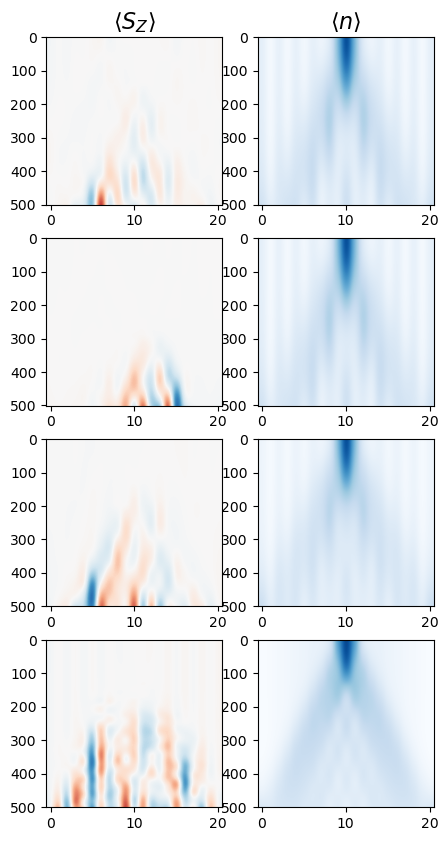

In [429]:
fig,ax = subplots(4,2,figsize=(5,10))
for i = 1:4
    ax[i,1].imshow(real.(scan_U_res_third[2*i-1]),vmin=-maximum(abs.(scan_U_res_third[2*i-1])),vmax=maximum(abs.(scan_U_res_third[2*i-1]))
                , aspect="auto", cmap="RdBu", interpolation="gaussian")
    ax[i,2].imshow(real.(scan_U_res_third[2*i]),vmin=0.0,vmax=maximum(real.(scan_U_res_third[2*i]))
                , aspect="auto", cmap="Blues_r", interpolation="gaussian")
end

ax[1,1].set_title(L"$\langle S_Z \rangle$", fontsize=16)
ax[1,2].set_title(L"$\langle n \rangle$", fontsize=16)

gcf()

In [430]:
colormap_name = "viridis"
num_colors = 4
cmap = get_cmap(colormap_name)
colors = [cmap(k/num_colors) for k in 0:num_colors-1]
for i = 1:div(length(scan_U_res_third[7][:,1]),10)
# i = 1
    fig,ax = subplots(2,1,figsize=(10,4))
    # for i = 1:length(scan_U_res_third[8][:,1])
    #     ax.plot(real.(scan_U_res_third[7][i,:]),color="black",label=L"$\langle S_Z \rangle$")
    # end


    ax[1].plot(real.(scan_U_res_third[2][10*i,:]),"-o", color=colors[1])
    ax[1].plot(real.(scan_U_res_third[4][10*i,:]),"-o", color=colors[2])
    ax[1].plot(real.(scan_U_res_third[6][10*i,:]),"-o", color=colors[3])
    ax[1].plot(real.(scan_U_res_third[8][10*i,:]),"-o", color=colors[4])
    ax[2].plot(real.(scan_U_res_third[1][10*i,:]),"-o", color=colors[1],label=Us[1])
    ax[2].plot(real.(scan_U_res_third[3][10*i,:]),"-o", color=colors[2],label=Us[2])
    ax[2].plot(real.(scan_U_res_third[5][10*i,:]),"-o", color=colors[3],label=Us[3])
    ax[2].plot(real.(scan_U_res_third[7][10*i,:]),"-o", color=colors[4],label=Us[4])
    ax[2].legend(fontsize=14, loc=(1.05,0.0), title=L"$U$")
    # ax[2].set_title(L"$t=$"*string(i*dt), fontsize=14)
    props = Dict("boxstyle" => "round", "facecolor" => "white", "alpha" => 1.0)
    ax[1].text(22.5,0.7,L"$t=$"*string(round(10*i*dt,digits=2)),bbox=props,fontsize=16)
    # boxstyle='round', facecolor='wheat', alpha=0.5
    ax[1].set_ylim([0.0,1.05])
    ax[2].set_ylim([-0.5,0.5])
    ax[2].set_xticks(0:2:20)
    ax[1].grid()
    ax[2].grid()

    ax[1].set_ylabel(L"$\langle n \rangle$", fontsize=14)
    ax[2].set_ylabel(L"$\langle S_z \rangle$", fontsize=14)
    fig.tight_layout()
    fig.savefig("timeevolutionviedo/plot_third"*string(i)*".png")
end
# gcf()

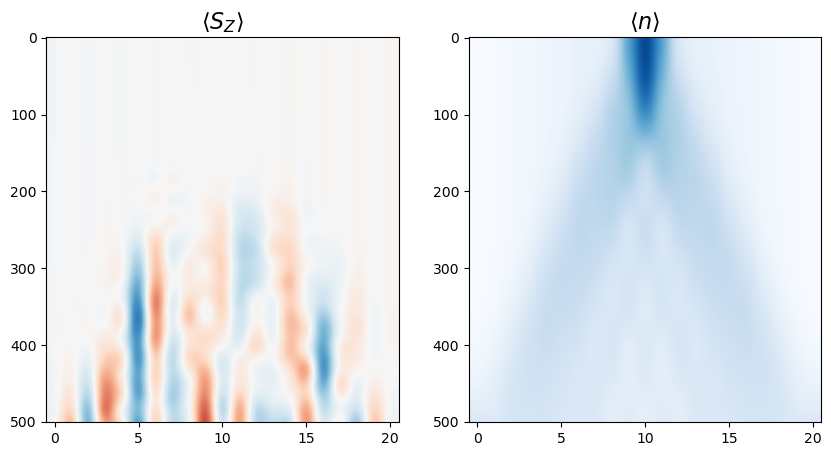

In [337]:
fig,ax = subplots(1,2,figsize=(10,5))
ax[1].imshow(real.(scan_U_res_third[7]),vmin=-maximum(abs.(scan_U_res_third[7])),vmax=maximum(abs.(scan_U_res_third[7]))
            , aspect="auto", cmap="RdBu", interpolation="gaussian")
ax[2].imshow(real.(scan_U_res_third[8]),vmin=0.0,vmax=maximum(real.(scan_U_res_third[8]))
            , aspect="auto", cmap="Blues_r", interpolation="gaussian")
# ax[2,1].imshow(real.(scan_U_res_s[1]),vmin=-maximum(abs.(scan_U_res_s[1])),vmax=maximum(abs.(scan_U_res_s[1]))
#             , aspect="auto", cmap="RdBu", interpolation="none")
# ax[2,2].imshow(real.(scan_U_res_s[2]),vmin=0.0,vmax=maximum(real.(scan_U_res_s[2]))
#             , aspect="auto", cmap="Blues_r", interpolation="none")

ax[1].set_title(L"$\langle S_Z \rangle$", fontsize=16)
ax[2].set_title(L"$\langle n \rangle$", fontsize=16)


gcf()

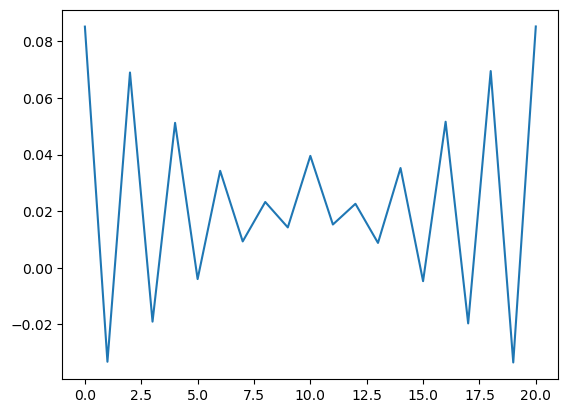

In [345]:
fig,ax=subplots()
ax.plot(real.(scan_U_res_e[7][500,:]))
# ax.plot(real.(scan_U_res_third[8][500,:]))

gcf()

In [298]:
L = 21
U = 0.0
E0, psi0 = Hubbard_DMRG(L,U,30,100,1/2)


filling factor is 0.5


After sweep 1 energy=-25.81067902204391  maxlinkdim=16 maxerr=6.72E-16 time=0.661


After sweep 2 energy=-25.962499425065825  maxlinkdim=100 maxerr=1.59E-07 time=2.703


After sweep 3 energy=-25.963585847257722  maxlinkdim=100 maxerr=1.90E-06 time=1.693


After sweep 4 energy=-25.963584999979787  maxlinkdim=100 maxerr=1.60E-06 time=1.555


After sweep 5 energy=-25.96358491018786  maxlinkdim=100 maxerr=1.59E-06 time=1.623


After sweep 6 energy=-25.963584910144032  maxlinkdim=100 maxerr=1.59E-06 time=1.621


After sweep 7 energy=-25.963584909762034  maxlinkdim=100 maxerr=1.59E-06 time=1.765


After sweep 8 energy=-25.963584909527228  maxlinkdim=100 maxerr=1.59E-06 time=1.503


After sweep 9 energy=-25.963584909394534  maxlinkdim=100 maxerr=1.59E-06 time=1.589


After sweep 10 energy=-25.963584909321234  maxlinkdim=100 maxerr=1.59E-06 time=1.692


After sweep 11 energy=-25.963584909281067  maxlinkdim=100 maxerr=1.59E-06 time=1.541


After sweep 12 energy=-25.963584909258895  maxlinkdim=100 maxerr=1.59E-06 time=1.509


After sweep 13 energy=-25.963584909245373  maxlinkdim=100 maxerr=1.59E-06 time=1.663


After sweep 14 energy=-25.963585954395562  maxlinkdim=100 maxerr=1.59E-06 time=1.527


After sweep 15 energy=-25.96358899159268  maxlinkdim=100 maxerr=1.61E-06 time=1.557


After sweep 16 energy=-25.96358898555872  maxlinkdim=100 maxerr=1.61E-06 time=1.735


After sweep 17 energy=-25.96358898031969  maxlinkdim=100 maxerr=1.60E-06 time=1.556


After sweep 18 energy=-25.963588976157222  maxlinkdim=100 maxerr=1.60E-06 time=1.699


After sweep 19 energy=-25.96358897322136  maxlinkdim=100 maxerr=1.60E-06 time=1.517


After sweep 20 energy=-25.963588971236675  maxlinkdim=100 maxerr=1.60E-06 time=1.534


After sweep 21 energy=-25.963588969883045  maxlinkdim=100 maxerr=1.60E-06 time=1.758


After sweep 22 energy=-25.963588968930193  maxlinkdim=100 maxerr=1.60E-06 time=1.567


After sweep 23 energy=-25.963588968224965  maxlinkdim=100 maxerr=1.60E-06 time=1.548


After sweep 24 energy=-25.963588967650495  maxlinkdim=100 maxerr=1.60E-06 time=1.740


After sweep 25 energy=-25.96358896708919  maxlinkdim=100 maxerr=1.60E-06 time=1.561


After sweep 26 energy=-25.96358896639549  maxlinkdim=100 maxerr=1.60E-06 time=1.610


After sweep 27 energy=-25.963588965405414  maxlinkdim=100 maxerr=1.60E-06 time=1.749


After sweep 28 energy=-25.96358896405752  maxlinkdim=100 maxerr=1.60E-06 time=1.601


After sweep 29 energy=-25.96358896263897  maxlinkdim=100 maxerr=1.60E-06 time=1.728


After sweep 30 energy=-25.963588962014637  maxlinkdim=100 maxerr=1.60E-06 time=1.543


ErrorException: syntax: invalid keyword argument syntax "30" around /Users/noamophir/Documents/GitHub/Computational-Methods-for-Many-Body-Physics/FinalProject/SpinChargeSeparation.ipynb:4

In [302]:
H = Hubbard_Hamiltonian(siteinds(psi0),U)
E1, psi1 = dmrg(H,[psi0],psi0;nsweeps=30,maxdim=100,cutoff=1E-8)

After sweep 1 energy=-25.92348781448079  maxlinkdim=100 maxerr=6.96E-05 time=2.989


After sweep 2 energy=-25.963274226903657  maxlinkdim=100 maxerr=3.45E-06 time=1.713


After sweep 3 energy=-25.963587109962507  maxlinkdim=100 maxerr=2.20E-06 time=1.712


After sweep 4 energy=-25.963588919520262  maxlinkdim=100 maxerr=1.61E-06 time=1.554


After sweep 5 energy=-25.963588779865784  maxlinkdim=100 maxerr=1.60E-06 time=1.722


After sweep 6 energy=-25.963588636210137  maxlinkdim=100 maxerr=1.60E-06 time=1.771


After sweep 7 energy=-25.963588642638435  maxlinkdim=100 maxerr=1.60E-06 time=1.676


After sweep 8 energy=-25.96358864745008  maxlinkdim=100 maxerr=1.60E-06 time=1.858


After sweep 9 energy=-25.963588650590186  maxlinkdim=100 maxerr=1.60E-06 time=1.652


After sweep 10 energy=-25.963588652354883  maxlinkdim=100 maxerr=1.60E-06 time=1.809


After sweep 11 energy=-25.963588653149863  maxlinkdim=100 maxerr=1.60E-06 time=1.681


After sweep 12 energy=-25.96358865327669  maxlinkdim=100 maxerr=1.60E-06 time=1.822


After sweep 13 energy=-25.9635886529383  maxlinkdim=100 maxerr=1.60E-06 time=1.682


After sweep 14 energy=-25.963588652284997  maxlinkdim=100 maxerr=1.60E-06 time=1.859


After sweep 15 energy=-25.963588651441068  maxlinkdim=100 maxerr=1.60E-06 time=1.824


After sweep 16 energy=-25.963588650507685  maxlinkdim=100 maxerr=1.60E-06 time=2.068


After sweep 17 energy=-25.96358864955796  maxlinkdim=100 maxerr=1.60E-06 time=1.731


After sweep 18 energy=-25.963588648636705  maxlinkdim=100 maxerr=1.60E-06 time=2.089


After sweep 19 energy=-25.96358864776605  maxlinkdim=100 maxerr=1.60E-06 time=2.117


After sweep 20 energy=-25.96358864695415  maxlinkdim=100 maxerr=1.60E-06 time=1.958


After sweep 21 energy=-25.96358864620159  maxlinkdim=100 maxerr=1.60E-06 time=1.891


After sweep 22 energy=-25.963588645505965  maxlinkdim=100 maxerr=1.60E-06 time=1.642


After sweep 23 energy=-25.963588644863897  maxlinkdim=100 maxerr=1.60E-06 time=1.779


After sweep 24 energy=-25.963588644272455  maxlinkdim=100 maxerr=1.60E-06 time=1.617


After sweep 25 energy=-25.963588643729604  maxlinkdim=100 maxerr=1.60E-06 time=1.790


After sweep 26 energy=-25.96358864323409  maxlinkdim=100 maxerr=1.60E-06 time=1.610


After sweep 27 energy=-25.963588642785385  maxlinkdim=100 maxerr=1.60E-06 time=2.042


After sweep 28 energy=-25.963588642382803  maxlinkdim=100 maxerr=1.60E-06 time=2.239


After sweep 29 energy=-25.96358864202504  maxlinkdim=100 maxerr=1.60E-06 time=1.846


After sweep 30 energy=-25.963588641709713  maxlinkdim=100 maxerr=1.60E-06 time=1.867


(-25.963588641709713, MPS
[1] ((dim=4|id=464|"Link,l=1") <Out>
 1: QN("Nf",19,-1) => 1
 2: QN("Nf",20,-1) => 2
 3: QN("Nf",21,-1) => 1, (dim=4|id=146|"Electron,Site,n=1") <Out>
 1: QN("Nf",0,-1) => 1
 2: QN("Nf",1,-1) => 2
 3: QN("Nf",2,-1) => 1)
[2] ((dim=16|id=946|"Link,l=2") <Out>
 1: QN("Nf",17,-1) => 1
 2: QN("Nf",18,-1) => 4
 3: QN("Nf",19,-1) => 6
 4: QN("Nf",20,-1) => 4
 5: QN("Nf",21,-1) => 1, (dim=4|id=241|"Electron,Site,n=2") <Out>
 1: QN("Nf",0,-1) => 1
 2: QN("Nf",1,-1) => 2
 3: QN("Nf",2,-1) => 1, (dim=4|id=464|"Link,l=1") <In>
 1: QN("Nf",19,-1) => 1
 2: QN("Nf",20,-1) => 2
 3: QN("Nf",21,-1) => 1)
[3] ((dim=4|id=938|"Electron,Site,n=3") <Out>
 1: QN("Nf",0,-1) => 1
 2: QN("Nf",1,-1) => 2
 3: QN("Nf",2,-1) => 1, (dim=58|id=679|"Link,l=3") <Out>
 1: QN("Nf",15,-1) => 1
 2: QN("Nf",16,-1) => 6
 3: QN("Nf",17,-1) => 13
 4: QN("Nf",18,-1) => 18
 5: QN("Nf",19,-1) => 13
 6: QN("Nf",20,-1) => 6
 7: QN("Nf",21,-1) => 1, (dim=16|id=946|"Link,l=2") <In>
 1: QN("Nf",17,-1) => 1
 2

In [304]:
E2, psi2 = dmrg(H,[psi0,psi1],psi0;nsweeps=30,maxdim=100,cutoff=1E-8)

After sweep 1 energy=-25.674662918782573  maxlinkdim=100 maxerr=1.89E-05 time=1.821


After sweep 2 energy=-25.67861974563955  maxlinkdim=100 maxerr=1.46E-05 time=1.886


After sweep 3 energy=-25.67862389648693  maxlinkdim=100 maxerr=1.11E-05 time=1.975


After sweep 4 energy=-25.678623919975756  maxlinkdim=100 maxerr=1.11E-05 time=1.947


After sweep 5 energy=-25.678622603147268  maxlinkdim=100 maxerr=1.11E-05 time=1.795


After sweep 6 energy=-25.678624189702763  maxlinkdim=100 maxerr=1.11E-05 time=2.020


After sweep 7 energy=-25.678624198631162  maxlinkdim=100 maxerr=1.11E-05 time=2.067


After sweep 8 energy=-25.678624208006475  maxlinkdim=100 maxerr=1.11E-05 time=1.903


After sweep 9 energy=-25.67862421718891  maxlinkdim=100 maxerr=1.11E-05 time=2.001


After sweep 10 energy=-25.67862423925434  maxlinkdim=100 maxerr=1.11E-05 time=2.009


After sweep 11 energy=-25.678624242315543  maxlinkdim=100 maxerr=1.11E-05 time=2.063


After sweep 12 energy=-25.678624251178338  maxlinkdim=100 maxerr=1.11E-05 time=1.869


After sweep 13 energy=-25.678624259899124  maxlinkdim=100 maxerr=1.11E-05 time=2.029


After sweep 14 energy=-25.678624268449603  maxlinkdim=100 maxerr=1.11E-05 time=2.087


After sweep 15 energy=-25.678624276833155  maxlinkdim=100 maxerr=1.11E-05 time=2.033


After sweep 16 energy=-25.678624285052816  maxlinkdim=100 maxerr=1.11E-05 time=1.862


After sweep 17 energy=-25.678624293369545  maxlinkdim=100 maxerr=1.11E-05 time=2.021


After sweep 18 energy=-25.678624300090604  maxlinkdim=100 maxerr=1.11E-05 time=2.081


After sweep 19 energy=-25.678624307833797  maxlinkdim=100 maxerr=1.11E-05 time=2.378


After sweep 20 energy=-25.67862431542294  maxlinkdim=100 maxerr=1.11E-05 time=2.366


After sweep 21 energy=-25.678624322863012  maxlinkdim=100 maxerr=1.11E-05 time=2.192


After sweep 22 energy=-25.67862433015669  maxlinkdim=100 maxerr=1.11E-05 time=2.123


After sweep 23 energy=-25.678624344588474  maxlinkdim=100 maxerr=1.11E-05 time=2.160


After sweep 24 energy=-25.678622774647827  maxlinkdim=100 maxerr=1.11E-05 time=1.911


After sweep 25 energy=-25.678624085678436  maxlinkdim=100 maxerr=1.11E-05 time=2.027


After sweep 26 energy=-25.678624092944666  maxlinkdim=100 maxerr=1.11E-05 time=2.098


After sweep 27 energy=-25.678624137292164  maxlinkdim=100 maxerr=1.11E-05 time=2.026


After sweep 28 energy=-25.678624144150504  maxlinkdim=100 maxerr=1.11E-05 time=1.842


After sweep 29 energy=-25.678624151017132  maxlinkdim=100 maxerr=1.11E-05 time=2.036


After sweep 30 energy=-25.678624157620803  maxlinkdim=100 maxerr=1.11E-05 time=2.023


(-25.678624157620803, MPS
[1] ((dim=4|id=774|"Link,l=1") <Out>
 1: QN("Nf",19,-1) => 1
 2: QN("Nf",20,-1) => 2
 3: QN("Nf",21,-1) => 1, (dim=4|id=146|"Electron,Site,n=1") <Out>
 1: QN("Nf",0,-1) => 1
 2: QN("Nf",1,-1) => 2
 3: QN("Nf",2,-1) => 1)
[2] ((dim=16|id=650|"Link,l=2") <Out>
 1: QN("Nf",17,-1) => 1
 2: QN("Nf",18,-1) => 4
 3: QN("Nf",19,-1) => 6
 4: QN("Nf",20,-1) => 4
 5: QN("Nf",21,-1) => 1, (dim=4|id=241|"Electron,Site,n=2") <Out>
 1: QN("Nf",0,-1) => 1
 2: QN("Nf",1,-1) => 2
 3: QN("Nf",2,-1) => 1, (dim=4|id=774|"Link,l=1") <In>
 1: QN("Nf",19,-1) => 1
 2: QN("Nf",20,-1) => 2
 3: QN("Nf",21,-1) => 1)
[3] ((dim=4|id=938|"Electron,Site,n=3") <Out>
 1: QN("Nf",0,-1) => 1
 2: QN("Nf",1,-1) => 2
 3: QN("Nf",2,-1) => 1, (dim=60|id=665|"Link,l=3") <Out>
 1: QN("Nf",15,-1) => 1
 2: QN("Nf",16,-1) => 6
 3: QN("Nf",17,-1) => 14
 4: QN("Nf",18,-1) => 18
 5: QN("Nf",19,-1) => 14
 6: QN("Nf",20,-1) => 6
 7: QN("Nf",21,-1) => 1, (dim=16|id=650|"Link,l=2") <In>
 1: QN("Nf",17,-1) => 1
 2

In [306]:
(E2-E1)/(2*pi/L)

0.9524236312160169

In [320]:
L = 20

E30, psi100 = Hubbard_DMRG(L,0.0,20,100,0.5)
E40, psi200 = Hubbard_DMRG(L,0.0,20,200,0.5)
E50, psi300 = Hubbard_DMRG(L,0.0,20,300,0.5)

(-24.76297993043037, MPS
[1] ((dim=4|id=343|"Link,l=1") <Out>
 1: QN("Nf",18,-1) => 1
 2: QN("Nf",19,-1) => 2
 3: QN("Nf",20,-1) => 1, (dim=4|id=156|"Electron,Site,n=1") <Out>
 1: QN("Nf",0,-1) => 1
 2: QN("Nf",1,-1) => 2
 3: QN("Nf",2,-1) => 1)
[2] ((dim=16|id=76|"Link,l=2") <Out>
 1: QN("Nf",16,-1) => 1
 2: QN("Nf",17,-1) => 4
 3: QN("Nf",18,-1) => 6
 4: QN("Nf",19,-1) => 4
 5: QN("Nf",20,-1) => 1, (dim=4|id=97|"Electron,Site,n=2") <Out>
 1: QN("Nf",0,-1) => 1
 2: QN("Nf",1,-1) => 2
 3: QN("Nf",2,-1) => 1, (dim=4|id=343|"Link,l=1") <In>
 1: QN("Nf",18,-1) => 1
 2: QN("Nf",19,-1) => 2
 3: QN("Nf",20,-1) => 1)
[3] ((dim=4|id=980|"Electron,Site,n=3") <Out>
 1: QN("Nf",0,-1) => 1
 2: QN("Nf",1,-1) => 2
 3: QN("Nf",2,-1) => 1, (dim=64|id=824|"Link,l=3") <Out>
 1: QN("Nf",14,-1) => 1
 2: QN("Nf",15,-1) => 6
 3: QN("Nf",16,-1) => 15
 4: QN("Nf",17,-1) => 20
 5: QN("Nf",18,-1) => 15
 6: QN("Nf",19,-1) => 6
 7: QN("Nf",20,-1) => 1, (dim=16|id=76|"Link,l=2") <In>
 1: QN("Nf",16,-1) => 1
 2: QN

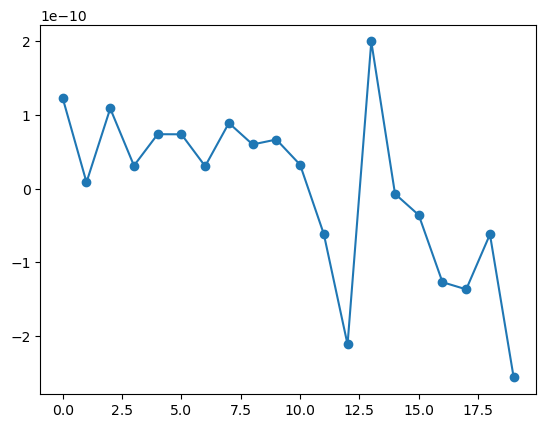

In [326]:
fig,ax=subplots()
# ax.plot(expect(psi100,"Ntot"),"-o")
# ax.plot(expect(psi200,"Ntot"),"-o")
ax.plot(expect(psi300,"Ntot") ,"-o")

gcf()

In [328]:
expect(psi100,"Ntot")

20-element Vector{Float64}:
 0.9999999983208347
 1.0000000016533657
 0.9999999950782528
 1.0000000047668118
 0.999999994309805
 0.9999999982227644
 0.9999999875249027
 1.0000000100486997
 1.0000000068889834
 1.0000000092639454
 0.9999999975609204
 1.0000000023539644
 0.9999999973490119
 1.0000000000606584
 0.9999999989688791
 0.9999999993575962
 0.9999999997895097
 0.9999999992228343
 0.9999999999662124
 0.9999999992920648

# $\nu\neq1/2$

In [440]:
L = 21
Ne = 23
dt = 1e-2
T = 5.0
Us = [0.0, 0.1, 1.0, 10.0]
scan_U_res_054 = []
for (i,U) in enumerate(Us)
    E, psi = Hubbard_DMRG(L,U,30,100,Ne/L/2)
    append!(scan_U_res_054,ExpValInTime(Quench(Quench(psi, "Cdn"), "Cup"), E, U, dt, T))
end

In [437]:
Ne = 23
@show Ne/L/2

0.5476190476190477

# Half filling, One electron quench

In [427]:
L = 21
dt = 1e-2
T = 5.0
Us = [0.0, 0.1, 1.0, 10.0]
scan_U_res_es = []
for (i,U) in enumerate(Us)
    E, psi = Hubbard_DMRG(L,U,30,100)
    append!(scan_U_res_es,ExpValInTime(Quench(psi,"Cup"), E, U, dt, T))
    # append!(scan_U_res_s,ExpValInTime(Quench(psi, "S-"), E, U, dt, T))
end

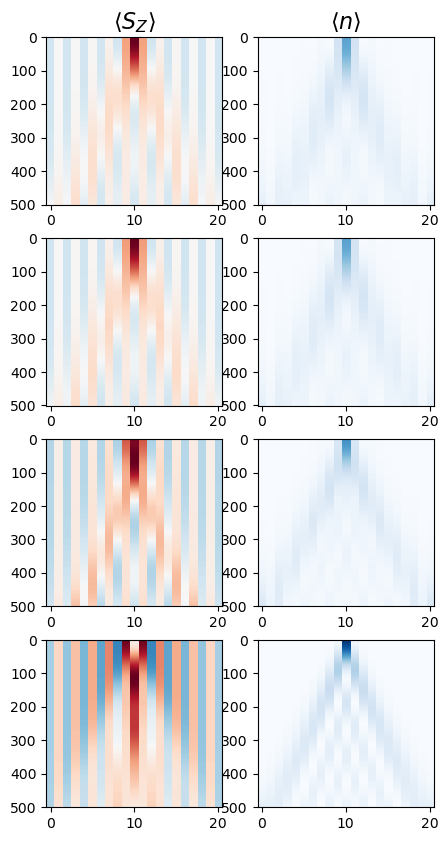

In [428]:
fig,ax = subplots(4,2,figsize=(5,10))
for i = 1:4
    ax[i,1].imshow(real.(scan_U_res_es[2*i-1]),vmin=-maximum(abs.(scan_U_res_e[2*i-1])),vmax=maximum(abs.(scan_U_res_e[2*i-1]))
                , aspect="auto", cmap="RdBu", interpolation="none")
    ax[i,2].imshow(real.(scan_U_res_es[2*i]),vmin=0.0,vmax=maximum(real.(scan_U_res_e[2*i]))
                , aspect="auto", cmap="Blues_r", interpolation="none")
end

ax[1,1].set_title(L"$\langle S_Z \rangle$", fontsize=16)
ax[1,2].set_title(L"$\langle n \rangle$", fontsize=16)

gcf()

In [502]:
colormap_name = "viridis"
num_colors = 4
cmap = get_cmap(colormap_name)
colors = [cmap(k/num_colors) for k in 0:num_colors-1]
for i = 1:length(scan_U_res_2[7][:,1])
# i = 40
    fig,ax = subplots(2,1,figsize=(10,4))
    # for i = 1:length(scan_U_res_2[8][:,1])
    #     ax.plot(real.(scan_U_res_2[7][i,:]),color="black",label=L"$\langle S_Z \rangle$")
    # end


    ax[1].plot(real.(scan_U_res_2[2][i,:]),"-o", color=colors[1])
    # ax[2].plot(real.(scan_U_res_2[1][i,:]),"-o", color=colors[1])
    ax[1].plot(real.(scan_U_res_2[4][i,:]),"-o", color=colors[2])
    ax[1].plot(real.(scan_U_res_2[6][i,:]),"-o", color=colors[3])
    ax[1].plot(real.(scan_U_res_2[8][i,:]),"-o", color=colors[4])
    ax[2].plot(real.(scan_U_res_2[1][i,:]),"-o", color=colors[1],label=Us[1])
    ax[2].plot(real.(scan_U_res_2[3][i,:]),"-o", color=colors[2],label=Us[2])
    ax[2].plot(real.(scan_U_res_2[5][i,:]),"-o", color=colors[3],label=Us[3])
    ax[2].plot(real.(scan_U_res_2[7][i,:]),"-o", color=colors[4],label=Us[4])
    ax[2].legend(fontsize=14, loc=(1.05,0.0), title=L"$U$")
    # ax[2].set_title(L"$t=$"*string(i*dt), fontsize=14)
    props = Dict("boxstyle" => "round", "facecolor" => "white", "alpha" => 1.0)
    ax[1].text(22.5,0.7,L"$t=$"*string(round(i*dt,digits=2)),bbox=props,fontsize=16)
    # boxstyle='round', facecolor='wheat', alpha=0.5
    ax[1].set_ylim([0.0,1.05])
    ax[2].set_ylim([-0.2,0.2])
    ax[2].set_xticks(0:2:20)
    ax[1].grid()
    ax[2].grid()

    ax[1].set_ylabel(L"$\langle n \rangle$", fontsize=14)
    ax[2].set_ylabel(L"$\langle S_z \rangle$", fontsize=14)
    fig.tight_layout()
    fig.savefig("timeevolutionviedo/plot_nu05_m033"*string(i)*".png")
end
# gcf()

In [488]:
size(scan_U_res_1[1])

(51, 21)

In [501]:
L = 21
Ne = 14
dt = 1e-1
T = 5.0
Us = [0.0, 0.1, 1.0, 10.0]
scan_U_res_2 = []
state0 = InitialState(L,L,7)
for (i,U) in enumerate(Us)
    E, psi = Hubbard_DMRG(L,U,30,100,state0)
    append!(scan_U_res_2,ExpValInTime(Quench(Quench(psi, "Cdn"), "Cup"), E, U, dt, T))
end

In [479]:
InitialState(5,5,1)

5-element Vector{Any}:
 "UpDn"
 "UpDn"
 "Up"
 "Emp"
 "Emp"